# Исследование для Яндекс.Афиши

### Цель исследования 
Проанализировать бизнес-показатели проекта, чтобы помочь маркетологам оптимизировать маркетинговые затраты. 
Для этого необходимо выяснить: 
- как люди пользуются продуктом;
- когда они начинают покупать; 
- сколько денег приносит каждый клиент; 
- когда клиент окупается. 

### Описание данных 

Таблица visits (лог сервера с информацией о посещениях сайта):
- Uid — уникальный идентификатор пользователя
- Device — категория устройства пользователя
- Start Ts — дата и время начала сессии
- End Ts — дата и время окончания сессии
- Source Id — идентификатор рекламного источника, из которого пришел пользователь

Таблица orders (информация о заказах):
- Uid — уникальный id пользователя, который сделал заказ
- Buy Ts — дата и время заказа
- Revenue — выручка Яндекс.Афиши с этого заказа

Таблица costs (информация о затратах на маркетинг):
- source_id — идентификатор рекламного источника
- dt — дата
- costs — затраты на этот рекламный источник в этот день

Данные за период с июня 2017 года по конец мая 2018 года. 



### План исследования 
1. [Открыть файлы с данными и изучить общую информацию](#step_1)
2. [Подготовить данные](#step_2)
<ul>
<li>Преобразовать данные в нужные типы.</li>
<li>Обработать пропуски при необходимости.</li>
<li>Проверить наличие дубликатов.</li>
</ul>
3. [Построить отчеты и посчитать метрики](#step_3): 
<ul>
<li>Продукт</li>
<li>Продажи</li>
<li>Маркетинг</li>
</ul>
4. [Общий вывод](#step_4)

<a id='step_1'></a>
### 1. Открыть файл с данными и изучить общую информацию

In [1]:
import pandas as pd 
import numpy as np
import seaborn as sns
from scipy import stats as st
import matplotlib.pyplot as plt

In [2]:
from pandas.plotting import register_matplotlib_converters
register_matplotlib_converters()

In [3]:
visits_log = pd.read_csv('visits_log.csv')
visits_log.head(10)

,Device,End Ts,Source Id,Start Ts,Uid
0,touch,2017-12-20 17:38:00,4,2017-12-20 17:20:00,16879256277535980062
1,desktop,2018-02-19 17:21:00,2,2018-02-19 16:53:00,104060357244891740
2,touch,2017-07-01 01:54:00,5,2017-07-01 01:54:00,7459035603376831527
3,desktop,2018-05-20 11:23:00,9,2018-05-20 10:59:00,16174680259334210214
4,desktop,2017-12-27 14:06:00,3,2017-12-27 14:06:00,9969694820036681168
5,desktop,2017-09-03 21:36:00,5,2017-09-03 21:35:00,16007536194108375387
6,desktop,2018-01-30 12:09:00,1,2018-01-30 11:13:00,6661610529277171451
7,touch,2017-11-05 15:15:00,3,2017-11-05 15:14:00,11423865690854540312
8,desktop,2017-07-19 10:44:00,3,2017-07-19 10:41:00,2987360259350925644
9,desktop,2017-11-08 13:43:00,5,2017-11-08 13:42:00,1289240080042562063


In [4]:
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype 
---  ------     --------------   ----- 
 0   Device     359400 non-null  object
 1   End Ts     359400 non-null  object
 2   Source Id  359400 non-null  int64 
 3   Start Ts   359400 non-null  object
 4   Uid        359400 non-null  uint64
dtypes: int64(1), object(3), uint64(1)
memory usage: 13.7+ MB


In [5]:
orders_log = pd.read_csv('orders_log.csv')
orders_log.head(10)

,Buy Ts,Revenue,Uid
0,2017-06-01 00:10:00,17.00,10329302124590727494
1,2017-06-01 00:25:00,0.55,11627257723692907447
2,2017-06-01 00:27:00,0.37,17903680561304213844
3,2017-06-01 00:29:00,0.55,16109239769442553005
4,2017-06-01 07:58:00,0.37,14200605875248379450
5,2017-06-01 08:43:00,0.18,10402394430196413321
6,2017-06-01 08:54:00,1.83,12464626743129688638
7,2017-06-01 09:22:00,1.22,3644482766749211722
8,2017-06-01 09:22:00,3.30,17542070709969841479
9,2017-06-01 09:23:00,0.37,1074355127080856382


In [6]:
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   Buy Ts   50415 non-null  object 
 1   Revenue  50415 non-null  float64
 2   Uid      50415 non-null  uint64 
dtypes: float64(1), object(1), uint64(1)
memory usage: 1.2+ MB


In [7]:
costs = pd.read_csv('costs.csv')
costs.head(10)

,source_id,dt,costs
0,1,2017-06-01,75.20
1,1,2017-06-02,62.25
2,1,2017-06-03,36.53
3,1,2017-06-04,55.00
4,1,2017-06-05,57.08
5,1,2017-06-06,40.39
6,1,2017-06-07,40.59
7,1,2017-06-08,56.63
8,1,2017-06-09,40.16
9,1,2017-06-10,43.24


In [8]:
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype  
---  ------     --------------  -----  
 0   source_id  2542 non-null   int64  
 1   dt         2542 non-null   object 
 2   costs      2542 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 59.7+ KB


### Вывод 
- Таблица visits_log содержит 5 столбцов и 359 400 строк. Данные не содержат пропусков. Названия столбцов необходимо привести к нижнему регистру, а также заменить пробелы на нижние подчеркивание. Также нужно изменить тип данных для столбцов Start Ts (дата и время начала сессии ) и End Ts (дата и время окончания сессии) на тип данных даты и времени: сейчас они имеют тип данных object. 
- Таблица orders_log содержит 3 столбца и 50 415 строк. Данные не содержат пропусков. Названия столбцов необходимо привести к нижнему регистру. Нужно изменить тип данных для столбца Buy Ts (дата и время заказа) на тип данных даты и времени: сейчас столбец имеет тип данных object. 
- Таблица costs содержит 3 столбца и 2 542 строки. Данные не содержат пропусков. Необходимо изменить тип данных для столбца dt (дата) на тип данных даты и времени: сейчас он имеет тип данных object. 

<a id='step_2'></a>
### 2. Подготовить данные

Приведем данные с указанием даты и времени к нужному типу данных для всех трех таблиц:

In [9]:
visits_log['Start Ts'] = pd.to_datetime(visits_log['Start Ts'], format='%Y%m%d %H:%M:%S')
visits_log['End Ts'] = pd.to_datetime(visits_log['End Ts'], format='%Y%m%d %H:%M:%S')
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   Device     359400 non-null  object        
 1   End Ts     359400 non-null  datetime64[ns]
 2   Source Id  359400 non-null  int64         
 3   Start Ts   359400 non-null  datetime64[ns]
 4   Uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [10]:
orders_log['Buy Ts'] = pd.to_datetime(orders_log['Buy Ts'], format='%Y%m%d %H:%M:%S')
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   Buy Ts   50415 non-null  datetime64[ns]
 1   Revenue  50415 non-null  float64       
 2   Uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [11]:
costs['dt'] = pd.to_datetime(costs['dt'], format='%Y-%m-%d')
costs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2542 entries, 0 to 2541
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype         
---  ------     --------------  -----         
 0   source_id  2542 non-null   int64         
 1   dt         2542 non-null   datetime64[ns]
 2   costs      2542 non-null   float64       
dtypes: datetime64[ns](1), float64(1), int64(1)
memory usage: 59.7 KB


Приведем столбцы к нижнему регистру и добавим нижнее подчеркивание для таблиц visits_log и orders_log: 

In [12]:
visits_log.columns = map(str.lower, visits_log.columns)
visits_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 359400 entries, 0 to 359399
Data columns (total 5 columns):
 #   Column     Non-Null Count   Dtype         
---  ------     --------------   -----         
 0   device     359400 non-null  object        
 1   end ts     359400 non-null  datetime64[ns]
 2   source id  359400 non-null  int64         
 3   start ts   359400 non-null  datetime64[ns]
 4   uid        359400 non-null  uint64        
dtypes: datetime64[ns](2), int64(1), object(1), uint64(1)
memory usage: 13.7+ MB


In [13]:
orders_log.columns = map(str.lower, orders_log.columns)
orders_log.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 50415 entries, 0 to 50414
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype         
---  ------   --------------  -----         
 0   buy ts   50415 non-null  datetime64[ns]
 1   revenue  50415 non-null  float64       
 2   uid      50415 non-null  uint64        
dtypes: datetime64[ns](1), float64(1), uint64(1)
memory usage: 1.2 MB


In [14]:
visits_log.columns = [x.lower().replace(' ', '_') for x in visits_log.columns.values]
orders_log.columns = [x.lower().replace(' ', '_') for x in orders_log.columns.values]

Проверим таблицы на наличие дубликатов: 

In [15]:
orders_log.duplicated().sum()

0

In [16]:
costs.duplicated().sum()

0

### Вывод 
- Во всех трех таблицах был исправлен тип данных для временных отметов на тип данные datetime. 
- Названия столбцов в таблицах visits_log и orders_log были приведены к нижнему регистру. Пропуски в названия столбцов были заменены на нижние подчеркивание. 
- В таблицах не было обнаружено дубликатов. 

<a id='step_3'></a>
### 3. Построить отчеты и посчитать метрики 

### Продукт

**Оценка пользовательской активности**: сколько людей пользуются продуктом в день, неделю, месяц? 

In [17]:
#Чтобы посчитать активность по дням, неделям и месяцам, выделим в отдельные столбцы полную дату, неделю, месяц и год: 
visits_log['session_date'] = visits_log['start_ts'].dt.date
visits_log['session_week'] = visits_log['start_ts'].dt.week
visits_log['session_month'] = visits_log['start_ts'].dt.month
visits_log['session_year'] = visits_log['start_ts'].dt.year

In [18]:
#Посчитаем метрики dau, wau и mau. Для этого сгрупируем данные по уникальным пользователям и найдем среднее: 
dau = visits_log.groupby('session_date').agg({'uid':'nunique'}).mean()
wau = visits_log.groupby(['session_year', 'session_week']).agg({'uid':'nunique'}).mean()
mau = visits_log.groupby(['session_year', 'session_month']).agg({'uid':'nunique'}).mean()
print('DAU:', int(dau))
print('WAU:', int(wau))
print('MAU:', int(mau))

DAU: 907
WAU: 5716
MAU: 23228


In [19]:
#Отобразим на графиках, как эти метрики меняются по устройствам: 
dau_device = visits_log.groupby(['device', 'session_date']).agg({'uid':'nunique'})
dau_device = dau_device.reset_index()

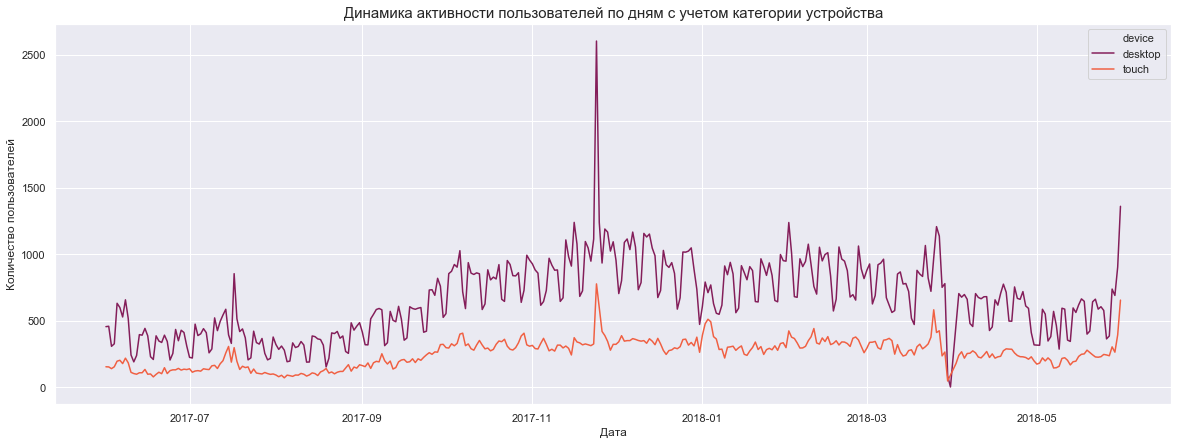

In [20]:
sns.set(style="darkgrid")
sns.set(rc={'figure.figsize':(20,7)})
dau_device_lineplot = sns.lineplot(x='session_date', 
                                   y='uid', 
                                   hue='device', 
                                   palette='rocket', 
                                   data=dau_device)
dau_device_lineplot.set(xlabel='Дата', 
                        ylabel='Количество пользователей')
dau_device_lineplot.axes.set_title('Динамика активности пользователей по дням с учетом категории устройства', 
                                   fontsize=15);

In [21]:
visits_log['session_week'] = visits_log['start_ts'].astype('datetime64[W]')
wau_device = visits_log.groupby(['device', 'session_week']).agg({'uid':'nunique'})
wau_device = wau_device.reset_index()

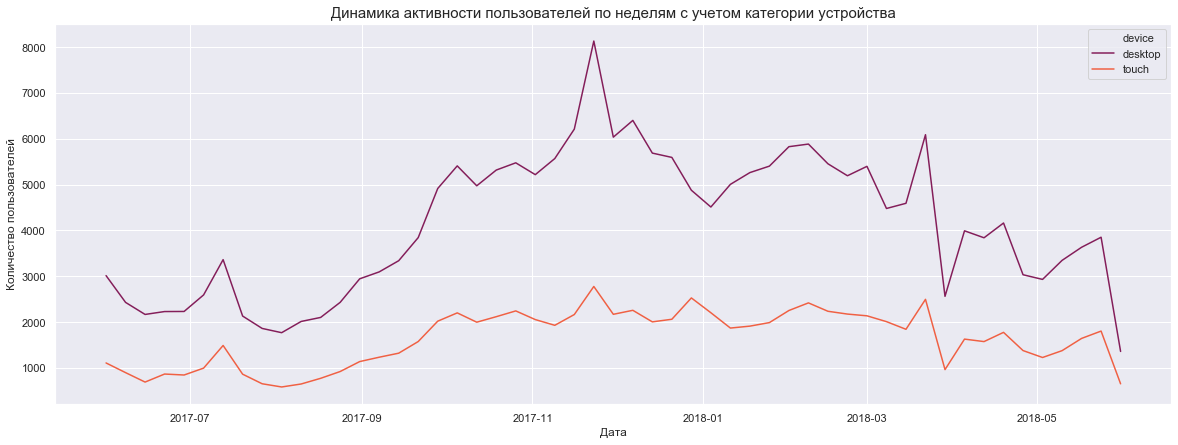

In [22]:
wau_device_lineplot = sns.lineplot(x='session_week', 
                                   y='uid', 
                                   hue='device', 
                                   palette='rocket', 
                                   data=wau_device)
wau_device_lineplot.set(xlabel='Дата', 
                        ylabel='Количество пользователей')
wau_device_lineplot.axes.set_title('Динамика активности пользователей по неделям с учетом категории устройства', 
                                   fontsize=15);

In [23]:
visits_log['session_month'] = visits_log['start_ts'].astype('datetime64[M]')
mau_device = visits_log.groupby(['device', 'session_month']).agg({'uid':'nunique'})
mau_device = mau_device.reset_index()

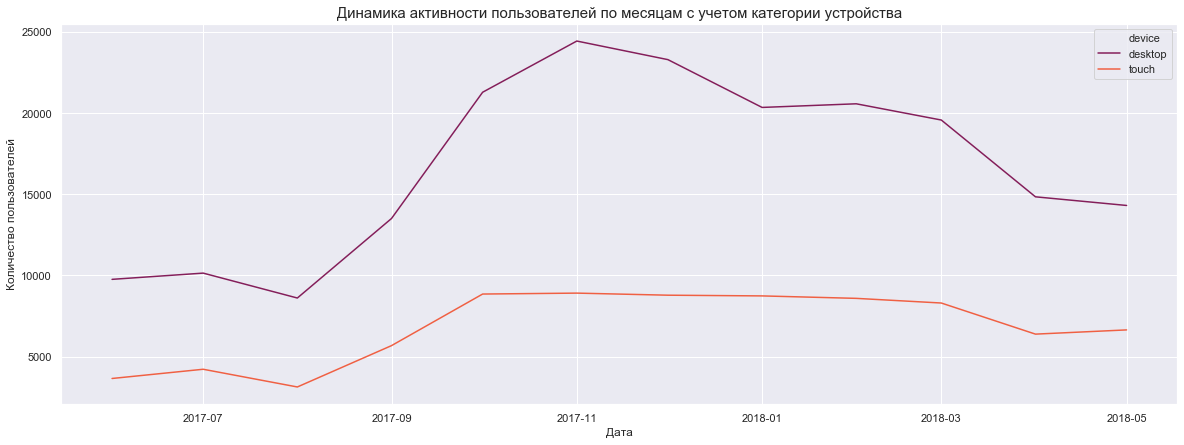

In [24]:
mau_device_lineplot = sns.lineplot(x='session_month', 
                                   y='uid', 
                                   hue='device', 
                                   palette='rocket', 
                                   data=mau_device)
mau_device_lineplot.set(xlabel='Дата', 
                        ylabel='Количество пользователей')
mau_device_lineplot.axes.set_title('Динамика активности пользователей по месяцам с учетом категории устройства', 
                                   fontsize=15);

In [25]:
#Посчитаем dau, wau и mau для декстопных устройств: 
desktop = visits_log.query('device == "desktop"')
dau_desktop = desktop.groupby('session_date').agg({'uid':'nunique'}).mean()
wau_desktop = desktop.groupby('session_week').agg({'uid':'nunique'}).mean()
mau_desktop = desktop.groupby('session_month').agg({'uid':'nunique'}).mean()
print('DAU для декстопных устройств:', int(dau_desktop))
print('WAU для декстопных устройств:', int(wau_desktop))
print('MAU для декстопных устройств:', int(mau_desktop))


DAU для декстопных устройств: 659
WAU для декстопных устройств: 4135
MAU для декстопных устройств: 16724


In [26]:
#Посчитаем dau, wau и mau для touch-устройств: 
touch = visits_log.query('device == "touch"')
dau_touch = touch.groupby('session_date').agg({'uid':'nunique'}).mean()
wau_touch = touch.groupby('session_week').agg({'uid':'nunique'}).mean()
mau_touch = touch.groupby('session_month').agg({'uid':'nunique'}).mean()
print('DAU для touch-устройств:', int(dau_touch))
print('WAU для touch-устройств:', int(wau_touch))
print('MAU для touch-устройств:', int(mau_touch))

DAU для touch-устройств: 252
WAU для touch-устройств: 1637
MAU для touch-устройств: 6825


In [27]:
#Отобразим, как эти метрики меняются по рекламным источникам: 
dau_source = visits_log.groupby(['source_id', 'session_date']).agg({'uid':'nunique'})
dau_source = dau_source.reset_index()

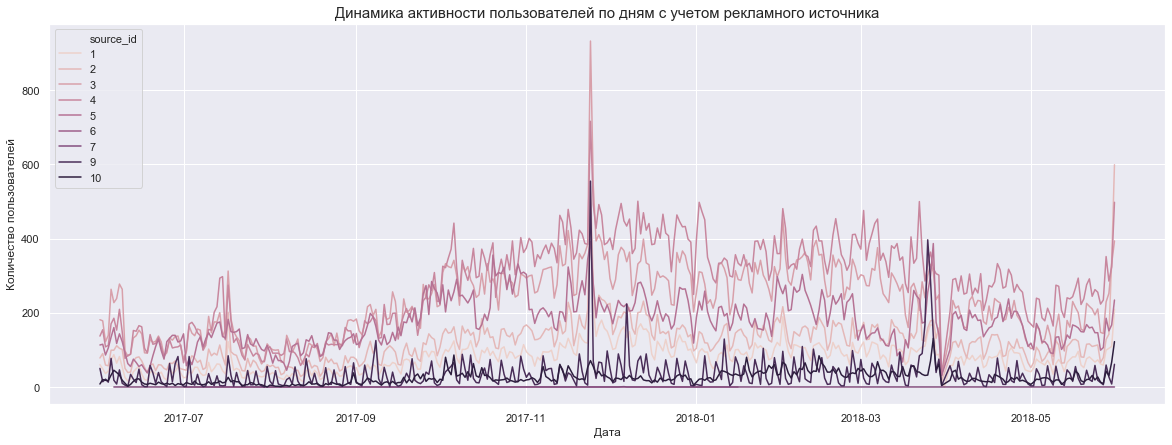

In [28]:
dau_source_lineplot = sns.lineplot(x='session_date', 
                                   y='uid', 
                                   hue='source_id', 
                                   legend='full', 
                                   data=dau_source)
dau_source_lineplot.set(xlabel='Дата', 
                        ylabel='Количество пользователей')
dau_source_lineplot.axes.set_title('Динамика активности пользователей по дням с учетом рекламного источника', 
                                   fontsize=15);

In [29]:
wau_source = visits_log.groupby(['source_id', 'session_week']).agg({'uid':'nunique'})
wau_source = wau_source.reset_index()

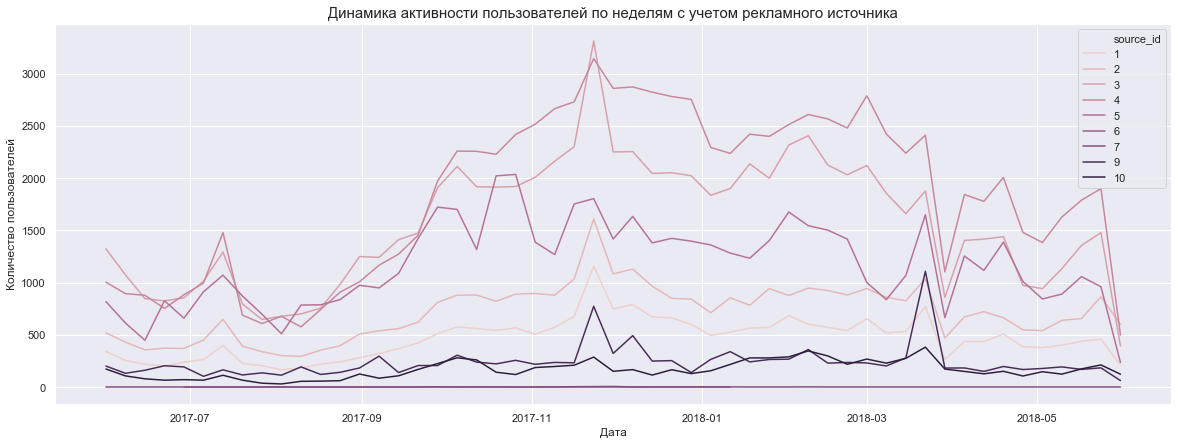

In [30]:
wau_source_lineplot = sns.lineplot(x='session_week', 
                                   y='uid', 
                                   hue='source_id', 
                                   legend='full', 
                                   data=wau_source)
wau_source_lineplot.set(xlabel='Дата', 
                        ylabel='Количество пользователей')
wau_source_lineplot.axes.set_title('Динамика активности пользователей по неделям с учетом рекламного источника', 
                                   fontsize=15);

In [31]:
mau_source = visits_log.groupby(['source_id', 'session_month']).agg({'uid':'nunique'})
mau_source = mau_source.reset_index()

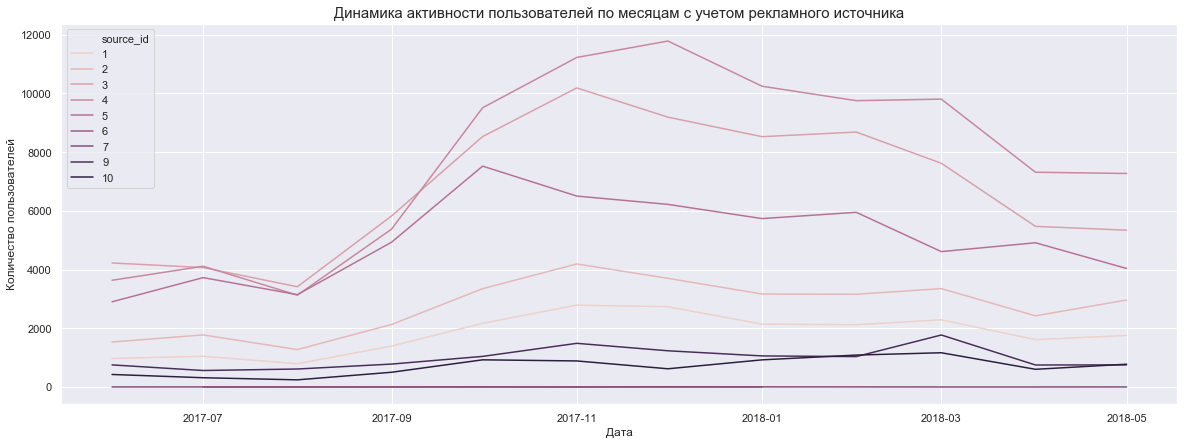

In [32]:
mau_source_lineplot = sns.lineplot(x='session_month', 
                                   y='uid', 
                                   hue='source_id', 
                                   legend='full',
                                   data=mau_source)
mau_source_lineplot.set(xlabel='Дата', 
                           ylabel='Количество пользователей')
mau_source_lineplot.axes.set_title('Динамика активности пользователей по месяцам с учетом рекламного источника', 
                                   fontsize=15);

In [33]:
#Рассчитаем показатели dau, wau, mau для каждого источника.
#Создадим список источников: 
sources_list = list(visits_log['source_id'].unique())
sources_list = sorted(sources_list)
#Создадим списки для показателей: 
dau_list = []
wau_list = []
mau_list = []
#Заполним списки показателей: 
for source in sources_list: 
    source_slice = visits_log.query('source_id == @source')
    dau_source = source_slice.groupby('session_date').agg({'uid':'nunique'}).mean() 
    dau_list.append(int(dau_source))
    wau_source = source_slice.groupby('session_week').agg({'uid':'nunique'}).mean() 
    wau_list.append(int(wau_source))
    mau_source = source_slice.groupby('session_month').agg({'uid':'nunique'}).mean() 
    mau_list.append(int(mau_source))

In [34]:
#Создадим датафрейм с показателями для каждого источника:
dau_wau_mau_sources = pd.DataFrame(np.array([dau_list, wau_list, mau_list]), 
                                   columns=sources_list, 
                                   index=['DAU', 'WAU', 'MAU'])
dau_wau_mau_sources

,1,2,3,4,5,6,7,9,10
DAU,80,120,232,275,175,1,1,36,26
WAU,464,716,1565,1830,1168,1,1,238,166
MAU,1818,2752,6758,7765,5017,1,2,987,707


#### Вывод 
- В среднем в день Яндекс.Афишу посещает 907 пользователей. Этот показатель равен 5 716 пользователей и 23 228 для недельной и месячной активности пользователей соответственно. 
- DAU, WAU, MAU с учетом категории устройства. Значительно большую активность проявляют пользователи desktop-устройств: разница для показателей примерно в два-три раза по сравнению с пользователями touch-устройств. Так, показатель DAU для десктопных устройств равен 659 по сравнению с показателем 252 для пользователей touch-устройств. Что касается WAU и MAU, то эти показатели для пользователей декстопа равны 4 135 и 16 724 соответственно, а для пользователей touch-устройств 1 637 и 6 825. Вероятно, десктопная версия сайта лучше оптимизирована, и поэтому пользователи отдают предпочтение именно ей. 
- DAU, WAU, MAU с учетом рекламного источника. Прежде всего, отметим, что не было зафиксировано активности пользователей для источника 8. Также наименьшей активностью характеризиуются источники 6 и 7 (в первом случае все три показателя равны единице, а во втором только показатель MAU равен 2). Наибольшей активностью характеризуются пользователи, которые увидили рекламу портала на источниках 3 и 4. Для источника 3 показатели DAU, WAU, MAU равны 232, 1565 и 6758 соответственно. Для источника 4 – 275, 1 830 и 7 765. Таким образом, на источники 3 и 4 стоит обратить внимание как на способ привлечь наиболее активных пользователей. 

**Пользовательская сессия**: cколько сессий в день? 

In [35]:
#Рассчитаем среднее количество сессий в день: 
sessions_per_day_mean = visits_log.groupby('session_date').agg({'uid':'count'}).mean()
sessions_per_day_device_mean = visits_log.groupby(['session_date', 'device']).agg({'uid':'count'}).mean()
sessions_per_day_source_mean = visits_log.groupby(['session_date', 'source_id']).agg({'uid':'count'}).mean()
print('Cреднее количество сессий в день:', int(sessions_per_day_mean))
print('Cреднее количество сессий в день с учетом категории устройства:', int(sessions_per_day_device_mean))
print('Cреднее количество сессий в день с учетом рекламного источника:', int(sessions_per_day_source_mean))

Cреднее количество сессий в день: 987
Cреднее количество сессий в день с учетом категории устройства: 494
Cреднее количество сессий в день с учетом рекламного источника: 139


In [36]:
#Визуализируем количество сессий по дням: 
sessions_per_day = visits_log.groupby('session_date').agg({'uid':'count'})
sessions_per_day = sessions_per_day.reset_index()

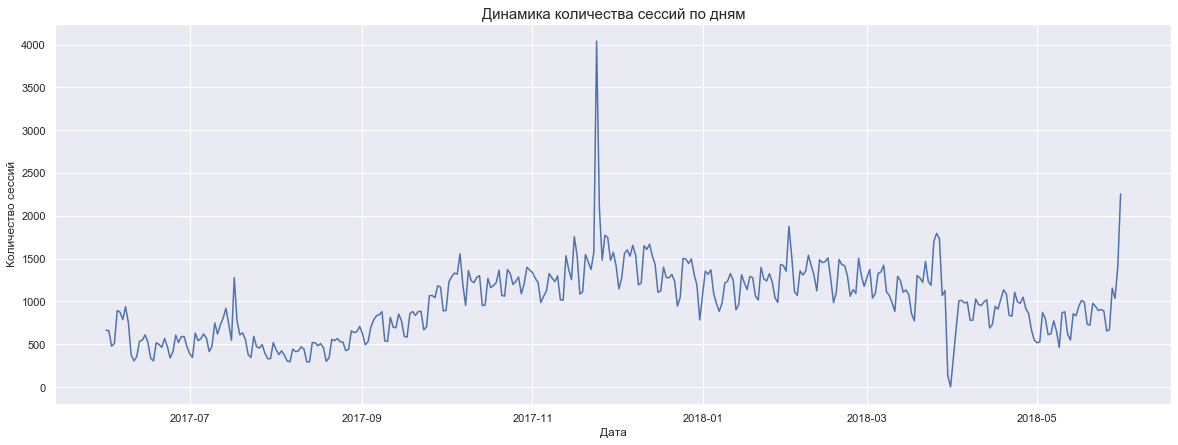

In [37]:
sessions_per_day_lineplot = sns.lineplot(x='session_date', 
                                         y='uid',  
                                         palette='rocket', 
                                         data=sessions_per_day)
sessions_per_day_lineplot.set(xlabel='Дата', 
                              ylabel='Количество сессий')
sessions_per_day_lineplot.axes.set_title('Динамика количества сессий по дням', 
                                         fontsize=15);

In [38]:
#Визуализируем количество сессий по дням с учетом типа устройства: 
sessions_per_day_device = visits_log.groupby(['session_date', 'device']).agg({'uid':'count'})
sessions_per_day_device = sessions_per_day_device.reset_index()

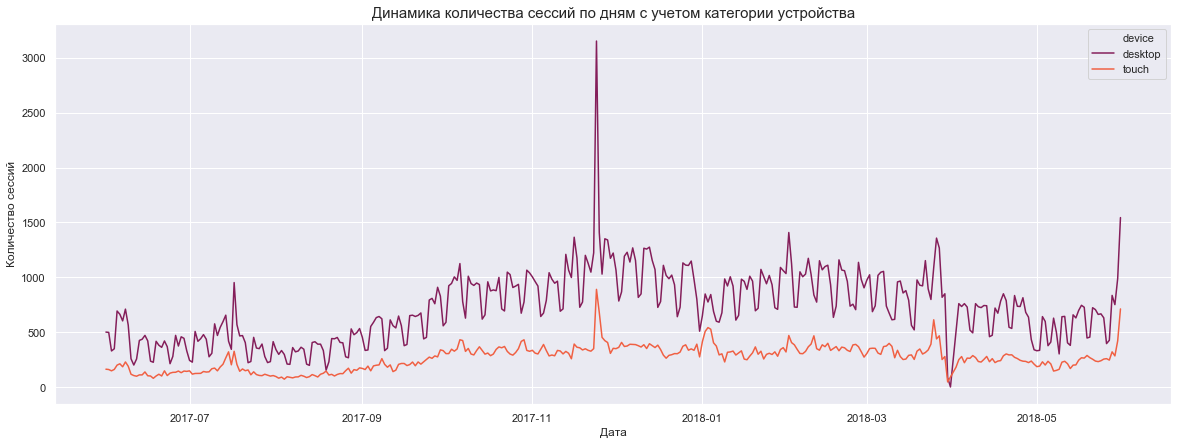

In [39]:
sessions_per_day_device_lineplot = sns.lineplot(x='session_date', 
                                   y='uid',  
                                   palette='rocket', 
                                   hue='device', 
                                   data=sessions_per_day_device)
sessions_per_day_device_lineplot.set(xlabel='Дата', 
                                     ylabel='Количество сессий')
sessions_per_day_device_lineplot.axes.set_title('Динамика количества сессий по дням с учетом категории устройства', 
                                                fontsize=15);

In [40]:
#Визуализируем количество сессий по дням с учетом рекламного источника: 
sessions_per_day_source = visits_log.groupby(['session_date', 'source_id']).agg({'uid':'count'})
sessions_per_day_source = sessions_per_day_source.reset_index()

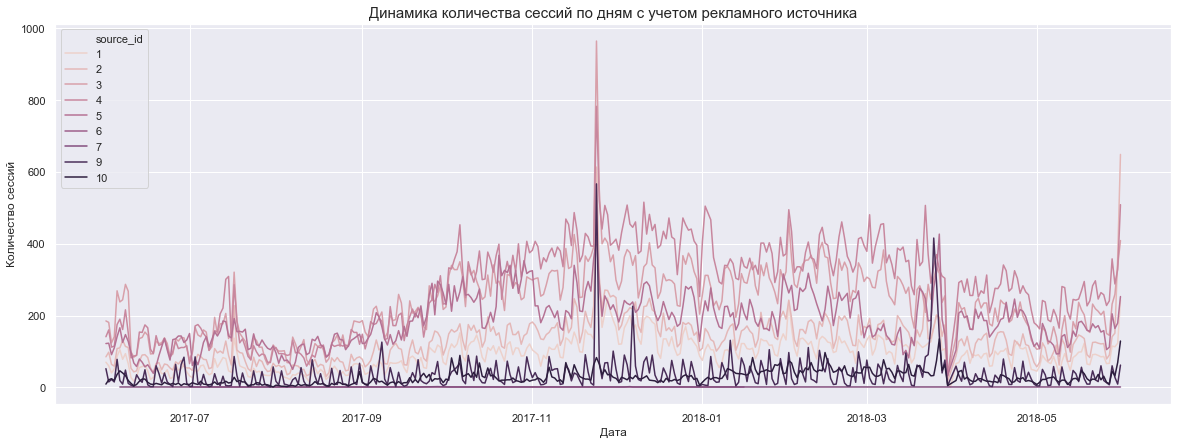

In [41]:
sessions_per_day_source_lineplot = sns.lineplot(x='session_date', 
                                   y='uid',  
                                   hue='source_id', 
                                   legend='full',
                                   data=sessions_per_day_source)
sessions_per_day_source_lineplot.set(xlabel='Дата', 
                                     ylabel='Количество сессий')
sessions_per_day_source_lineplot.axes.set_title('Динамика количества сессий по дням с учетом рекламного источника', 
                                                fontsize=15);

#### Вывод 
- Среднее количество сессий в день – 987.
- Количество сессий в среднем по категории устройств - 494. 
- Количество сессий в среднем по рекламным источникам - 139. 
- Что касается динамики количества сессий, то ожидаемо наибольшее количество сессий приходтся на период с нобря 2017 года по январь 2018 года, когда пользователи уходят на новогодние каникулы. 

**Средняя продолжительность сессии (ASL)**

In [42]:
#Рассчитаем среднюю продолжительность сессии в секундах: 
visits_log['session_duration_sec'] = (visits_log['end_ts'] - visits_log['start_ts']).dt.seconds
visits_log['session_duration_sec'].mean()

643.506488592098

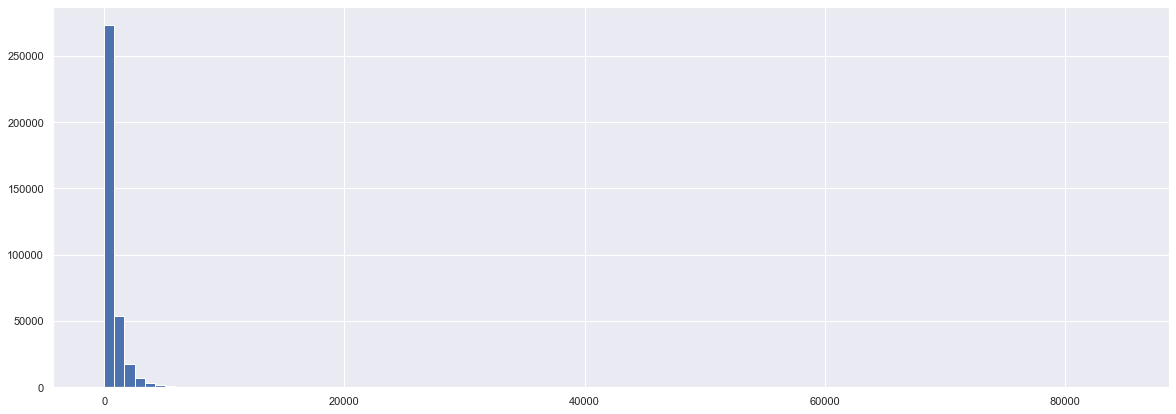

In [43]:
#Дополнительно построим гистограмму по этому параметру:
visits_log['session_duration_sec'].hist(bins=100);

In [44]:
#Рассчитаеем моду:
visits_log['session_duration_sec'].mode()

0    60
dtype: int64

#### Вывод 
- В среднем сессия пользователя длится около 11 минут (643 секунды). Однако данные распределны не нормально, и если ориентироваться на показатель моды, то наиболее часто встречаются пользователи, которые провели на сайте всего одно минуту. 

**Retention rate**: как часто люди возвращаются? 

In [45]:
#Так как наши данные за два года, построим когорты по месяцам. Для этого возьмем дату, 
#когда пользователь впервые воспользовался сервисом: 
first_activity_date = visits_log.groupby(['uid'])['session_date'].min()
first_activity_date.name = 'first_activity_date'

In [46]:
#Добавим этот параметр к датафрему visits_log: 
visits_log = visits_log.join(first_activity_date, on='uid', lsuffix='_left', rsuffix='_right')

In [47]:
#Выделим месяц, когда пользователь впервые зашел на Яндекс.Афишу:
visits_log['first_activity_month'] = visits_log['first_activity_date'].astype('datetime64[M]')

In [48]:
#Добавим lifetime: 
visits_log['cohort_lifetime'] = visits_log['session_month'] - visits_log['first_activity_month'] 
visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'] / np.timedelta64(1,'M')
visits_log['cohort_lifetime'] = visits_log['cohort_lifetime'].round().astype('int')

In [49]:
#Сгруппируем данные по когорте и lifetime: 
cohorts = visits_log.groupby(['first_activity_month','cohort_lifetime']).agg({'uid':'nunique'}).reset_index()

In [50]:
#Retention rate рассчитывается по формуле: отношение кол-ва активных пользователей 
#на n-ый lifetime к кол-ву активных пользователей на 0-lifetime. 
#Сначала найдем исходное число пользователей в когорте: 
initial_users_count = cohorts[cohorts['cohort_lifetime'] == 0][['first_activity_month','uid']]
initial_users_count = initial_users_count.rename(columns={'uid':'cohort_users'})

In [51]:
#Объединим данные по когортам: 
cohorts = cohorts.merge(initial_users_count,on='first_activity_month')

In [52]:
#Рассчитаем retention rate: 
cohorts['retention'] = cohorts['uid']/cohorts['cohort_users']

In [53]:
#Посмтроим сводную таблицу, на основе которой построим тепловую карту: 
retention_pivot = cohorts.pivot_table(index='first_activity_month',
                                      columns='cohort_lifetime',
                                      values='retention',
                                      aggfunc='sum')

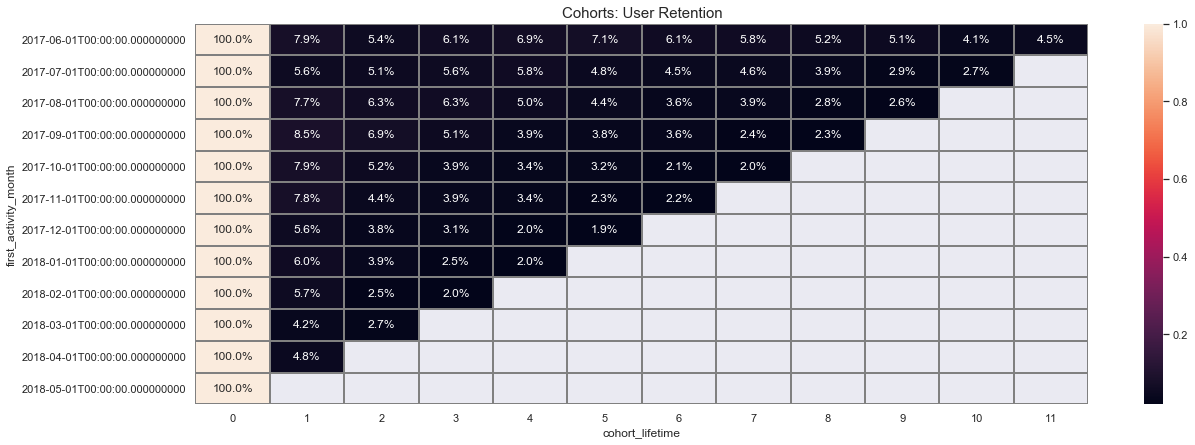

In [54]:
cohorts_heatmap = sns.heatmap(retention_pivot, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
cohorts_heatmap.axes.set_title('Cohorts: User Retention', fontsize=15);

In [55]:
#Проделаем все тоже самое с учетом категории устройства: 
cohorts_device = visits_log.groupby(['first_activity_month', 'device', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count_device = cohorts_device[cohorts_device['cohort_lifetime'] == 0][['first_activity_month', 'device','uid']]
initial_users_count_device = initial_users_count_device.rename(columns={'uid':'cohort_users'})
cohorts_device = cohorts_device.merge(initial_users_count_device,on=['first_activity_month', 'device'])
cohorts_device['retention'] = cohorts_device['uid']/cohorts_device['cohort_users']
retention_pivot_device = cohorts_device.pivot_table(index=['first_activity_month','device'],
                                                    columns='cohort_lifetime',values='retention',
                                                    aggfunc='sum')


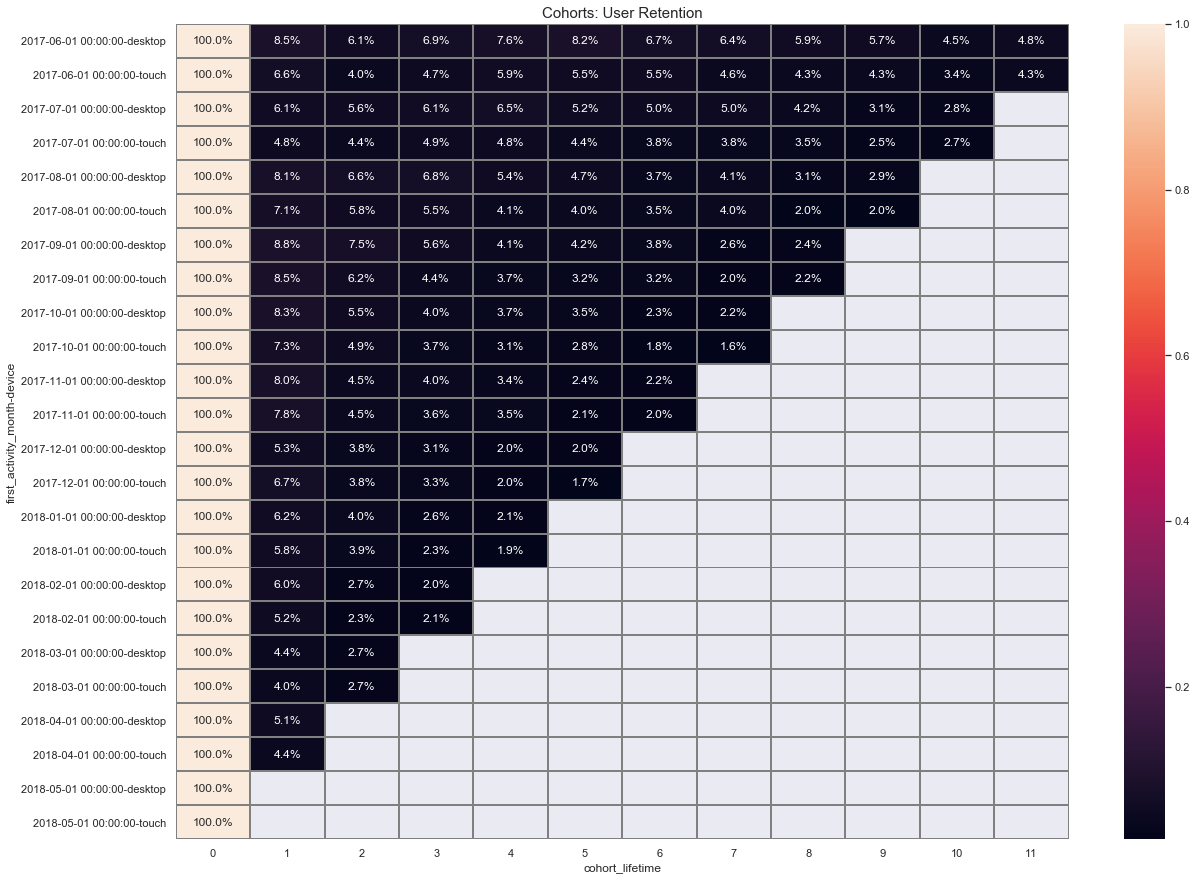

In [56]:
plt.figure(figsize = (20,15))
cohorts_device_heatmap = sns.heatmap(retention_pivot_device, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
cohorts_device_heatmap.axes.set_title('Cohorts: User Retention', fontsize=15);

In [57]:
#Проделаем все тоже самое с учетом рекламного источника: 
cohorts_source = visits_log.groupby(['first_activity_month', 'source_id', 'cohort_lifetime']).agg({'uid':'nunique'}).reset_index()
initial_users_count_source = cohorts_source[cohorts_source['cohort_lifetime'] == 0][['first_activity_month', 'source_id','uid']]
initial_users_count_source = initial_users_count_source.rename(columns={'uid':'cohort_users'})
cohorts_source = cohorts_source.merge(initial_users_count_source,on=['first_activity_month', 'source_id'])
cohorts_source['retention'] = cohorts_source['uid']/cohorts_source['cohort_users']
retention_pivot_source = cohorts_source.pivot_table(index=['source_id', 'first_activity_month'],
                                                    columns='cohort_lifetime',values='retention',
                                                    aggfunc='sum')

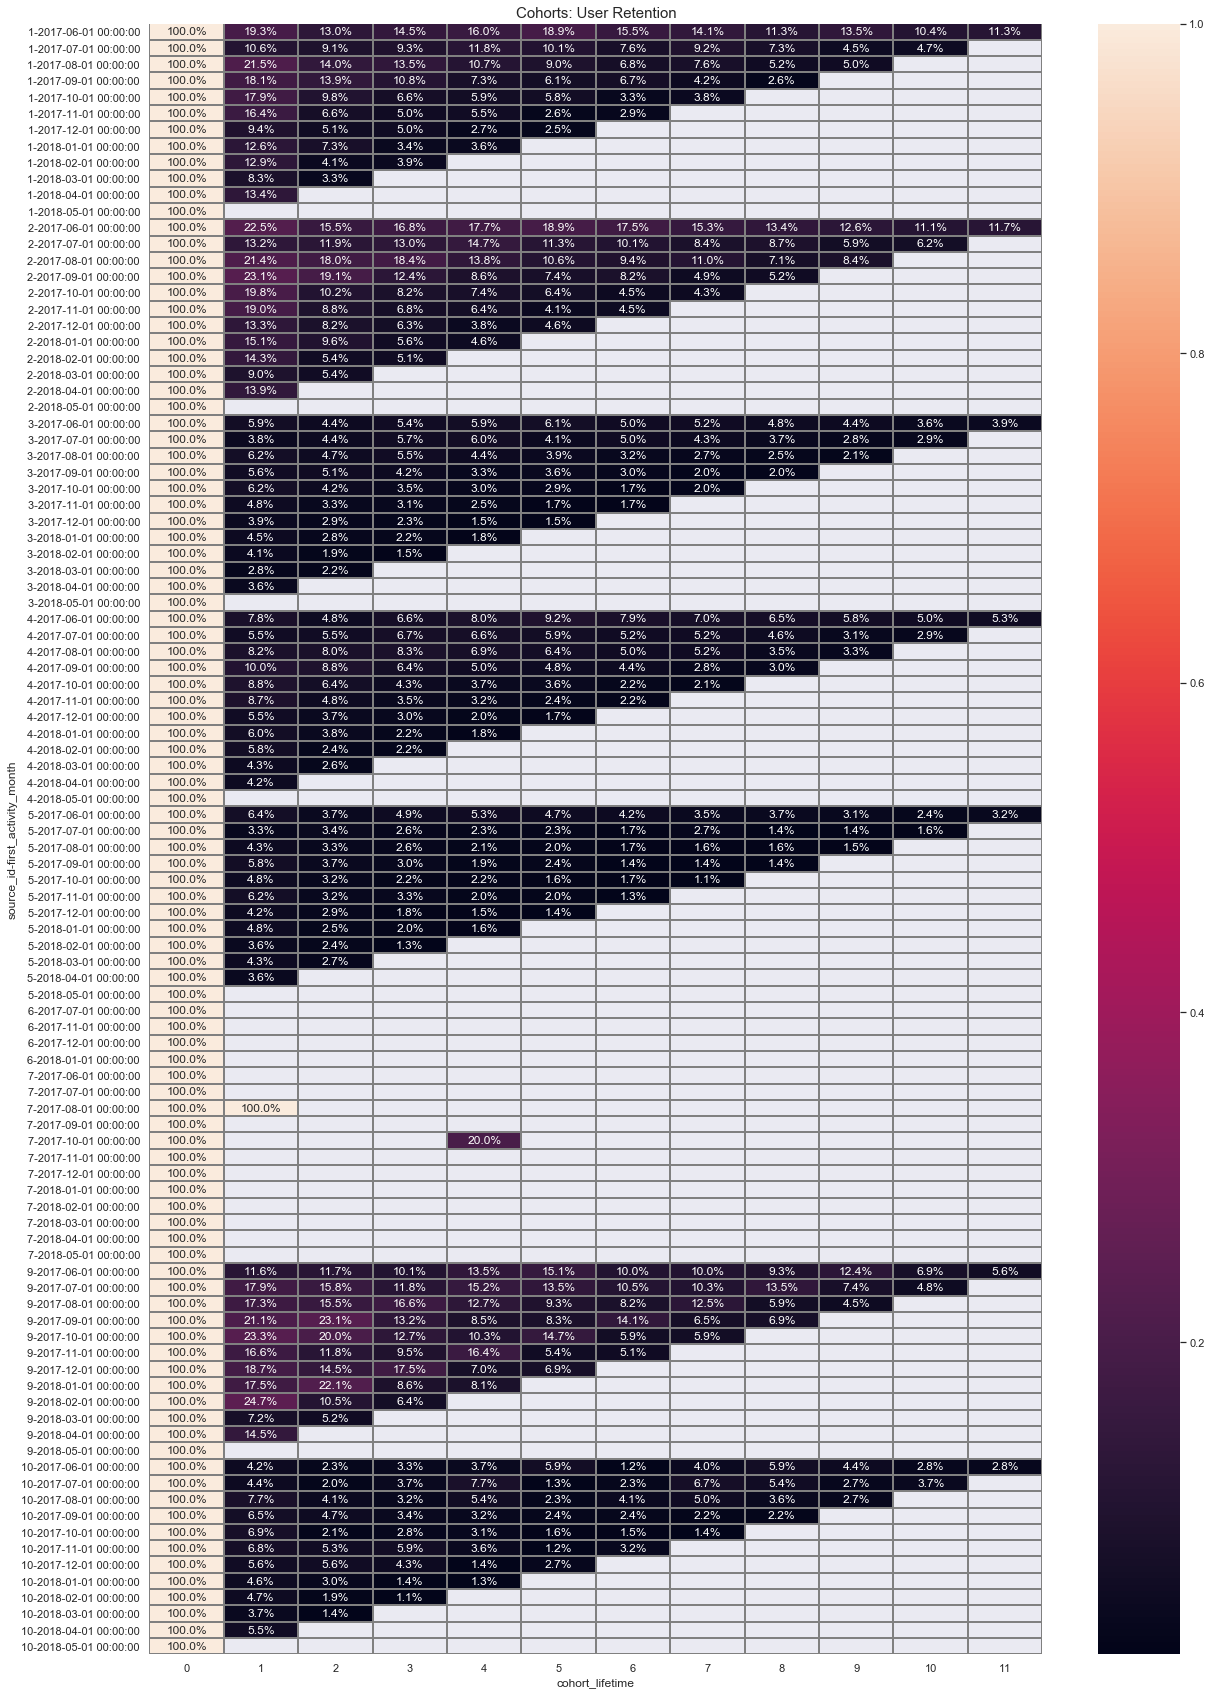

In [58]:
plt.figure(figsize = (20,30))
cohorts_source_heatmap = sns.heatmap(retention_pivot_source, annot=True, fmt='.1%', linewidths=1, linecolor='gray')
cohorts_source_heatmap.axes.set_title('Cohorts: User Retention', fontsize=15);

#### Вывод
- Резюмируя данные тепловой карты для всего набора данных можно сказать, что в целом этот показатель довольно низкий на протяжении всей жизни когорт, так как не привышает 10%. Также стоит отметить, что с появлением каждой новой когрты показатель удержания немного снижается. Так, для пользователей, которые впервые воспользовались потралом в июне, он равен 7,9%, то для вперпые пришедших на Яндекс.Афишу в феврале 2018 года он равен 5,7%. То есть можно сделать вывод, что с каждой новой когоротой поведение пользователей меняется. 
- Что касается retention rate по категории устройства, то можно отметить, что в целом этот показатель, пусть и незначительно, выше для десктопных устройств. Например, для когорты пользователей февраля 2018 года для desktop retention rate равен 6%, а для touch 5,2%. Исключеним является только когорта пользователей, которые впервые посетили сайт в декабре 2017 года. Возможно, сайт лучше оптимизирован именно для десктопных, а не мобильных устройств. 
- Наиболее выскойи показатель удержания характерен для источников с номерами 1, 2 и 9. Следует сказать, что этот показатель также снижается с появлением новых когорт. Например, для источника 1 retention rate для когорты июня 2017 равен 19,3%, а марта 2018 года 8,3%. Наиболее низкий retention rate можно выделить для источников 3 и 5. 

### Общий вывод 
- DAU Яндекс Афиши равен 907, WAU — 5 716, MAU — 23 228. 
- Пользователи значительно чаще обращаются к порталу с десктопных, а не touch-устройств: разница для показателей примерно в два-три раза по сравнению с пользователями touch-устройств. Возможно, мобильная версия сайта требует доработки или дополнительного исследования поведения пользователей. 
- Наиболее активно пользователи пользовались порталом в декабре 2017 - январе 2018 года, что может объясняться новогодними каникулами, когда у людей больше времени на развлечения. 
- Для источника 8 не было выявлено активности пользователей. Минимальной активностью характеризиуются источники 6 и 7 (в первом случае все три показателя равны единице, а во втором только показатель MAU равен 2). Наибольшей активностью источники 3 и 4. Для источника 3 показатели DAU, WAU, MAU равны 232, 1565 и 6758 соответственно. Для источника 4 – 275, 1 830 и 7 765. Таким образом, на источники 3 и 4 стоит обратить внимание как на способ привлечь наиболее активных пользователей. 
- В среднем на портале за эти два года в день совершалось 987 сессий. Этот же показатель с учетом категории устройства равен 494, а с учетом рекламного источника – 139. 
- Ожидаемо  наибольшее количество сессий приходтся на период с нобря 2017 года по январь 2018 года. 
- Пользовательская сессия в среднем длится около 11 минут, однако данные распределены не нормально и лучше ориентироваться на показатель моды, который равен ровно одной минуте. 
- Показатель удержания пользователей на портале довольно низкий: возвращается менее 10% пользователей. Более того, с появлением каждой новой когорты этот показатель незначительно, но снижается. Если для тех, кто впервые воспользовался порталом в июне 2017 года, он равен 7,9%, то для вперпые пришедших на Яндекс.Афишу в феврале 2018 года он равен 5,7%.Кроме того, чем больше lifetime когорты, тем ниже коэфициент удержания. 
- Показатель удержания незначительно, но выше для десктопных устройств. . Например, для когорты пользователей февраля 2018 года для desktop retention rate равен 6%, а для touch 5,2%. Исключеним является только когорта пользователей, которые впервые посетили сайт в декабре 2017 года. 
- Источники 1, 2 и 9 характеризуются наиболее высокими показателями удержания, а 3 и 5 наиболее низкими, хотя для них и была зафиксирована довольно высокая пользовательская активность. 

### Продажи

**Когда люди начинают покупать**? 

In [59]:
#Проанализируем, сколько времени проходит от 1го посещения сервиса до 1ой покупки. 
first_order = orders_log.groupby(['uid'])['buy_ts'].min()
first_order.name = 'first_order'

In [60]:
#Выделим из дата фрейма visits_log нужный нм набор данных: 
visits_for_orders = visits_log[['uid', 'device', 'source_id', 'session_date', 'first_activity_date' ]]

In [61]:
#Добавим дату и время первой покупки к датафрейму visits_for_orders: 
visits_for_orders = visits_for_orders.join(first_order, on='uid')

In [62]:
#Приведем дату и время первой покупки к дате: 
visits_for_orders['first_order_date'] = visits_for_orders['first_order'].dt.date

In [63]:
#Добавим столбец с количеством дней, которые прошли до первой покупки: 
visits_for_orders['days_before_order'] = visits_for_orders['first_order_date'] - visits_for_orders['first_activity_date']
visits_for_orders['days_before_order'] = visits_for_orders['days_before_order']/np.timedelta64(1,'D')

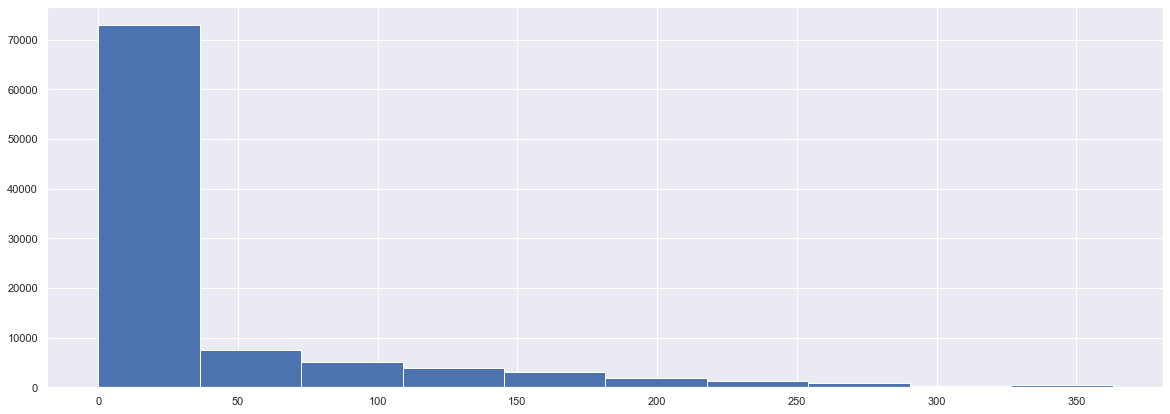

In [64]:
visits_for_orders['days_before_order'].hist();

In [65]:
#Учитывая распределение данных, дополнительно посмотрим моду для этого показателя:
visits_for_orders['days_before_order'].mode()

0    0.0
dtype: float64

In [66]:
visits_for_orders['days_before_order'].describe()

count    97394.000000
mean        33.713750
std         63.348208
min          0.000000
25%          0.000000
50%          1.000000
75%         37.000000
max        363.000000
Name: days_before_order, dtype: float64

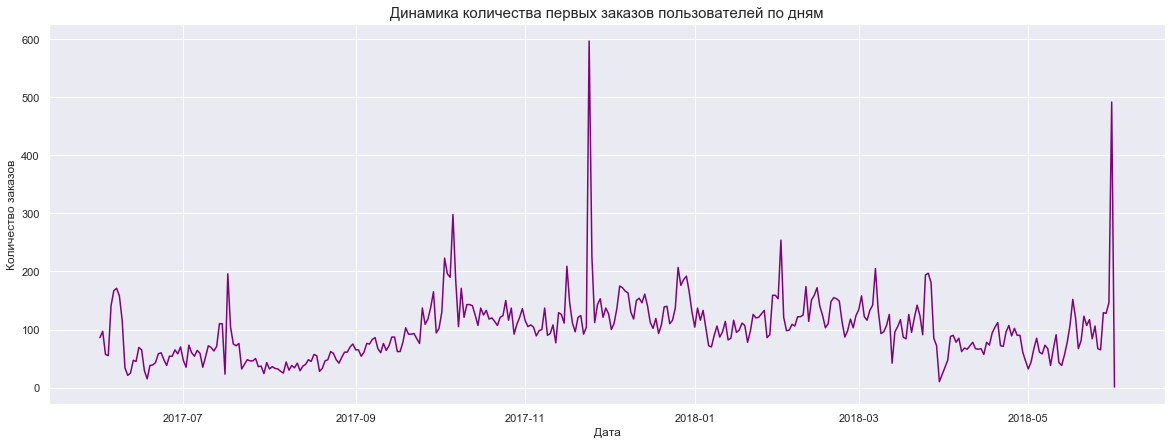

In [67]:
#Дополнительно посмотрим, как количество первыых заказов распределно во времени: 
first_order_date = visits_for_orders.groupby(['first_order_date']).agg({'uid':'nunique'})
first_order_date = first_order_date.reset_index()
first_order_date_lineplot = sns.lineplot(x='first_order_date', 
                                         y='uid', 
                                         color='purple', 
                                         data=first_order_date)
first_order_date_lineplot.set(xlabel='Дата', 
                              ylabel='Количество заказов')
first_order_date_lineplot.axes.set_title('Динамика количества первых заказов пользователей по дням', 
                                         fontsize=15);

In [68]:
#Дополнительно посмотрим, на какие даты пришелся пик покупательской активности: 
first_order_date.sort_values(by='uid', ascending=False)[:10]

,first_order_date,uid
176,2017-11-24,597
362,2018-05-31,492
127,2017-10-06,298
245,2018-02-01,254
177,2017-11-25,225
124,2017-10-03,223
168,2017-11-16,209
208,2017-12-26,207
279,2018-03-07,205
298,2018-03-26,197


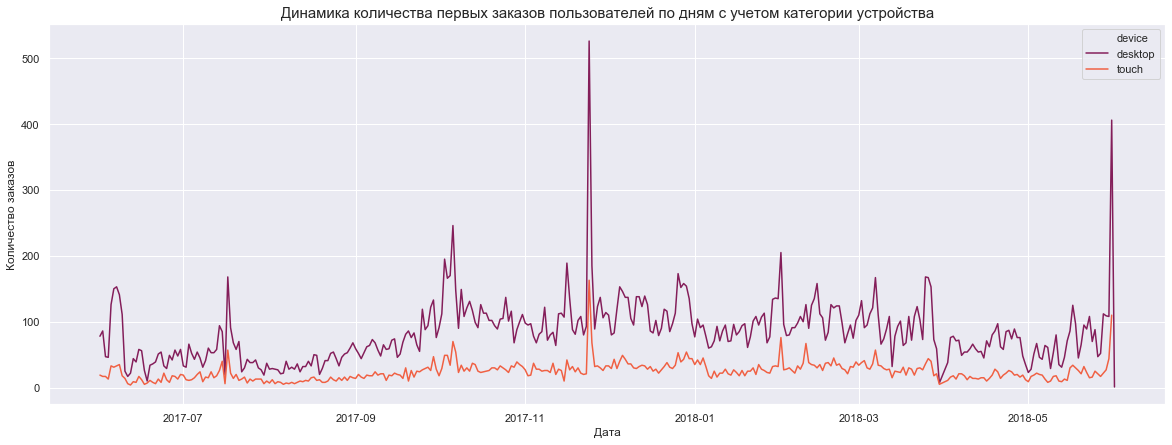

In [69]:
first_order_date_device = visits_for_orders.groupby(['device', 'first_order_date']).agg({'uid':'nunique'})
first_order_date_device = first_order_date_device.reset_index()
first_order_date_device_lineplot = sns.lineplot(x='first_order_date', 
                            y='uid', 
                            hue='device',                     
                            palette='rocket', 
                            data=first_order_date_device)
first_order_date_device_lineplot.set(xlabel='Дата', 
                                     ylabel='Количество заказов')
first_order_date_device_lineplot.axes.set_title('Динамика количества первых заказов пользователей по дням с учетом категории устройства', 
                                                fontsize=15);

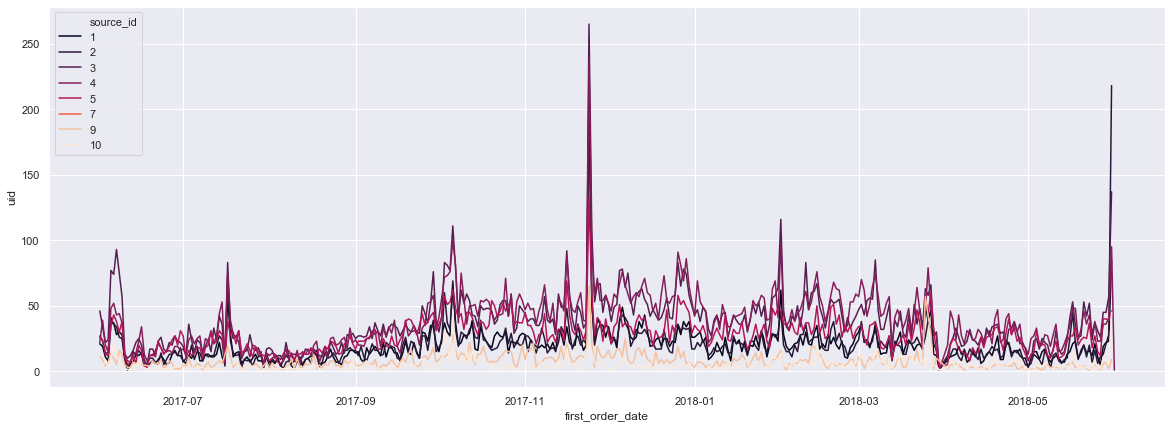

In [70]:
first_order_date_source = visits_for_orders.groupby(['source_id', 'first_order_date']).agg({'uid':'nunique'})
first_order_date_source = first_order_date_source.reset_index()
first_order_date_source_lineplot = sns.lineplot(x='first_order_date', 
                            y='uid', 
                            hue='source_id',
                            legend='full',
                            palette='rocket', 
                            data=first_order_date_source)
first_order_date_device_lineplot.set(xlabel='Дата', 
                           ylabel='Количество заказов')
first_order_date_device_lineplot.axes.set_title('Динамика количества первых заказов пользователей по дням с учетом категории устройства', 
                                                fontsize=15);

#### Вывод: 
- В среднем с момента посещения сайта до первой покупки проходит больше месяца (34 дня), однако данные распределны не нормально. Наиболее часто встречаются случаи, когда пользователь совершил покупку в тот же день, когда посетил сайт. Если посмотреть на распределение данных на квратили, то можно сказать, что в 50% случаев пользователи совершают покупку либо в тот же день, когда они посетили сайт, либо через день. 
- Что касается динамики первых покупок на портале пользователями, то график ожидаем визуально повторяет график активности пользователей. Наиболее часто покупки совершались в ноябре 2017 года (макисмальное количество покупок приходится на 24 ноября – 597 покупок). Это может объясняться желанием пользователей отвлечься от осенней хандры и весело провести время. Большее количество покупок было совершено на десктопных устройствах. Что касается распределения по рекламным источником, то здесь наилучше динамикой характеризуются покупки для 3 источника. 

**Сколько раз покупают за период?**

In [71]:
#Рассчитаем среднее количество покупок за день, неделю и месяц: 
orders_log['order_date'] = orders_log['buy_ts'].dt.date
orders_log['order_week'] = orders_log['buy_ts'].astype('datetime64[W]')
orders_log['order_month'] = orders_log['buy_ts'].astype('datetime64[M]')
orders_mean_day = orders_log.groupby(['order_date']).agg({'uid':'count'}).mean()
orders_mean_week = orders_log.groupby(['order_week']).agg({'uid':'count'}).mean()
orders_mean_month = orders_log.groupby(['order_month']).agg({'uid':'count'}).mean()
print('Среднее число покупок в день:', int(orders_mean_day)) 
print('Среднее число покупок в неделю:', int(orders_mean_week))
print('Среднее число покупок в месяц:', int(orders_mean_month))

Среднее число покупок в день: 138
Среднее число покупок в неделю: 951
Среднее число покупок в месяц: 3878


#### Вывод 
- В среднем в день пользователи совершают 138 покупок. Этот показатель равен 951 и 3 878 для покупок за неделю и месяц соответственно. 

**Какой средний чек?**

In [72]:
#Добавим дату первого заказа к датафрейму orders_log: 
orders_log = orders_log.join(first_order, on='uid')

In [73]:
#Получим первую дату каждого месяца совершения покупки: 
orders_log['first_order_month'] = orders_log['first_order'].astype('datetime64[M]')

In [74]:
#Cгруппируем данные по когортам: 
orders_grouped_by_cohorts = orders_log.groupby(['first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})
orders_grouped_by_cohorts.head()

revenue   uid
first_order_month order_month               
2017-06-01        2017-06-01   9557.49  2023
                  2017-07-01    981.82    61
                  2017-08-01    885.34    50
                  2017-09-01   1931.30    54
                  2017-10-01   2068.58    88

In [75]:
#Найдем средний чек покупателя:
orders_grouped_by_cohorts['revenue_per_user'] = orders_grouped_by_cohorts['revenue'] / orders_grouped_by_cohorts['uid']
orders_grouped_by_cohorts = orders_grouped_by_cohorts.reset_index()

In [76]:
#Найдем lifetime когорты: из месяца совершения заказа вычтем месяц когорты: 
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['order_month'] - orders_grouped_by_cohorts['first_order_month']
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
orders_grouped_by_cohorts['cohort_lifetime'] = orders_grouped_by_cohorts['cohort_lifetime'].round().astype('int')
orders_grouped_by_cohorts['first_order_month'] = orders_grouped_by_cohorts['first_order_month'].dt.strftime('%Y-%m')
#Построим сводную таблицу изменения среднего чека: 
revenue_per_user_pivot = orders_grouped_by_cohorts.pivot_table(index='first_order_month',
                                                               columns='cohort_lifetime',
                                                               values='revenue_per_user',
                                                               aggfunc='mean')


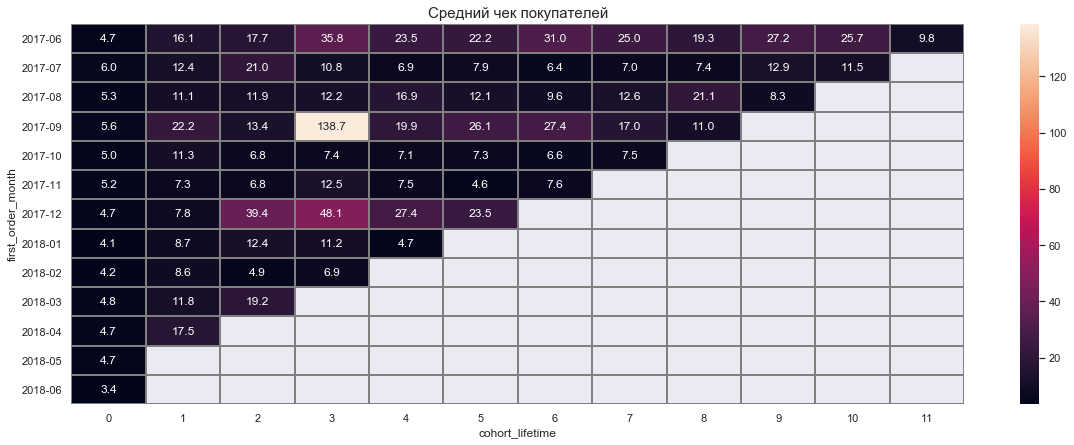

In [77]:
#Визуализируем таблицу полученную на предыдущем шаге: 
plt.title('Средний чек покупателей', fontsize=15)
sns.heatmap(revenue_per_user_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray');

In [78]:
#Нам необходимо добавть информацию по устройству покупателя. 
#Для этого из датафрейма visits_log выберем необходимый нам набор данных: 
session_device = visits_log[['device','end_ts','start_ts','uid','first_activity_month']]
session_device=pd.DataFrame(data=session_device)

In [79]:
#Добавим информацию о заказах: 
session_device = session_device.merge(orders_log, on=['uid'], how='inner')

In [80]:
#Оставим только те случаи, когда пользователем была совершена покупка. 
#Логично предположить, что покупка может произойти не раньше начала сессии и не позже ее окончания: 
session_device_orders = session_device.query('buy_ts >= start_ts and buy_ts <= end_ts')

In [81]:
#Проделаем все то же самое, что на предыдущем этапе и визуализируем полученный резульатат: 
sessions_device_by_cohorts = session_device_orders.groupby(['device','first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})
sessions_device_by_cohorts['revenue_per_user'] = sessions_device_by_cohorts['revenue'] / sessions_device_by_cohorts['uid']
sessions_device_by_cohorts = sessions_device_by_cohorts.reset_index()
sessions_device_by_cohorts['cohort_lifetime'] = sessions_device_by_cohorts['order_month'] - sessions_device_by_cohorts['first_order_month']
sessions_device_by_cohorts['cohort_lifetime'] = sessions_device_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
sessions_device_by_cohorts['cohort_lifetime'] = sessions_device_by_cohorts['cohort_lifetime'].round().astype('int')
sessions_device_by_cohorts['first_order_month'] = sessions_device_by_cohorts['first_order_month'].dt.strftime('%Y-%m')




In [82]:
sessions_device_by_cohorts_pivot = sessions_device_by_cohorts.pivot_table(index=['device','first_order_month'],
                                                                          columns='cohort_lifetime',
                                                                          values='revenue_per_user',
                                                                          aggfunc='mean')

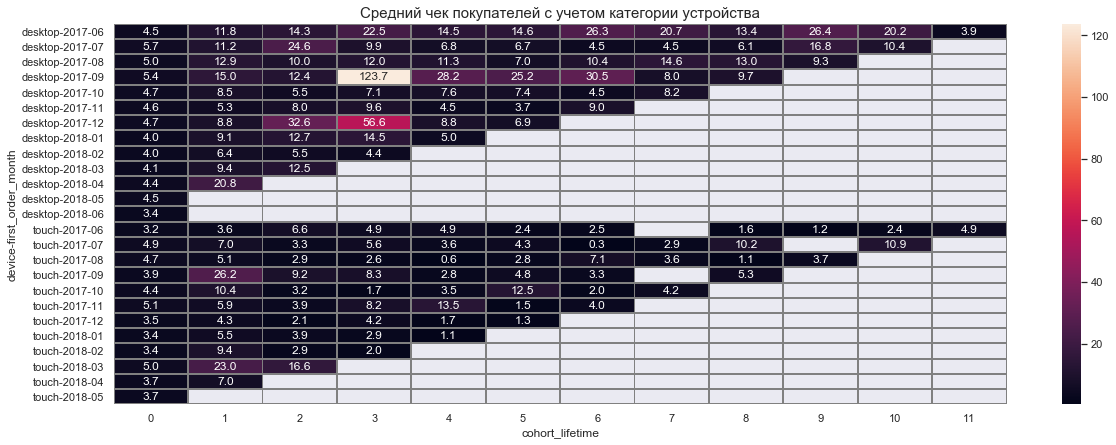

In [83]:
plt.title('Средний чек покупателей с учетом категории устройства', fontsize=15)
sns.heatmap(sessions_device_by_cohorts_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray');

In [84]:
#Также, как и для категории устройства выделим необходимые данные из фреймфорка visits_log, произведем необходимые подсчеты,
#визуализируем полученный результат: 
session_source = visits_log[['source_id','end_ts','start_ts','uid','first_activity_month']]
session_source=pd.DataFrame(data=session_source)

In [85]:
session_source = session_source.merge(orders_log, on=['uid'], how='inner')

In [86]:
session_source_orders = session_source.query('buy_ts >= start_ts and buy_ts <= end_ts')

In [87]:
session_source_by_cohorts = session_source_orders.groupby(['source_id','first_order_month','order_month']).agg({'revenue':'sum','uid':'nunique'})
session_source_by_cohorts['revenue_per_user'] = session_source_by_cohorts['revenue'] / session_source_by_cohorts['uid']
session_source_by_cohorts = session_source_by_cohorts.reset_index()
session_source_by_cohorts['cohort_lifetime'] = session_source_by_cohorts['order_month'] - session_source_by_cohorts['first_order_month']
session_source_by_cohorts['cohort_lifetime'] = session_source_by_cohorts['cohort_lifetime'] / np.timedelta64(1,'M')
session_source_by_cohorts['cohort_lifetime'] = session_source_by_cohorts['cohort_lifetime'].round().astype('int')
session_source_by_cohorts['first_order_month'] = session_source_by_cohorts['first_order_month'].dt.strftime('%Y-%m')

In [88]:
session_source_by_cohorts_pivot = session_source_by_cohorts.pivot_table(index=['source_id','first_order_month'],
                                                                        columns='cohort_lifetime',
                                                                        values='revenue_per_user',
                                                                        aggfunc='mean')

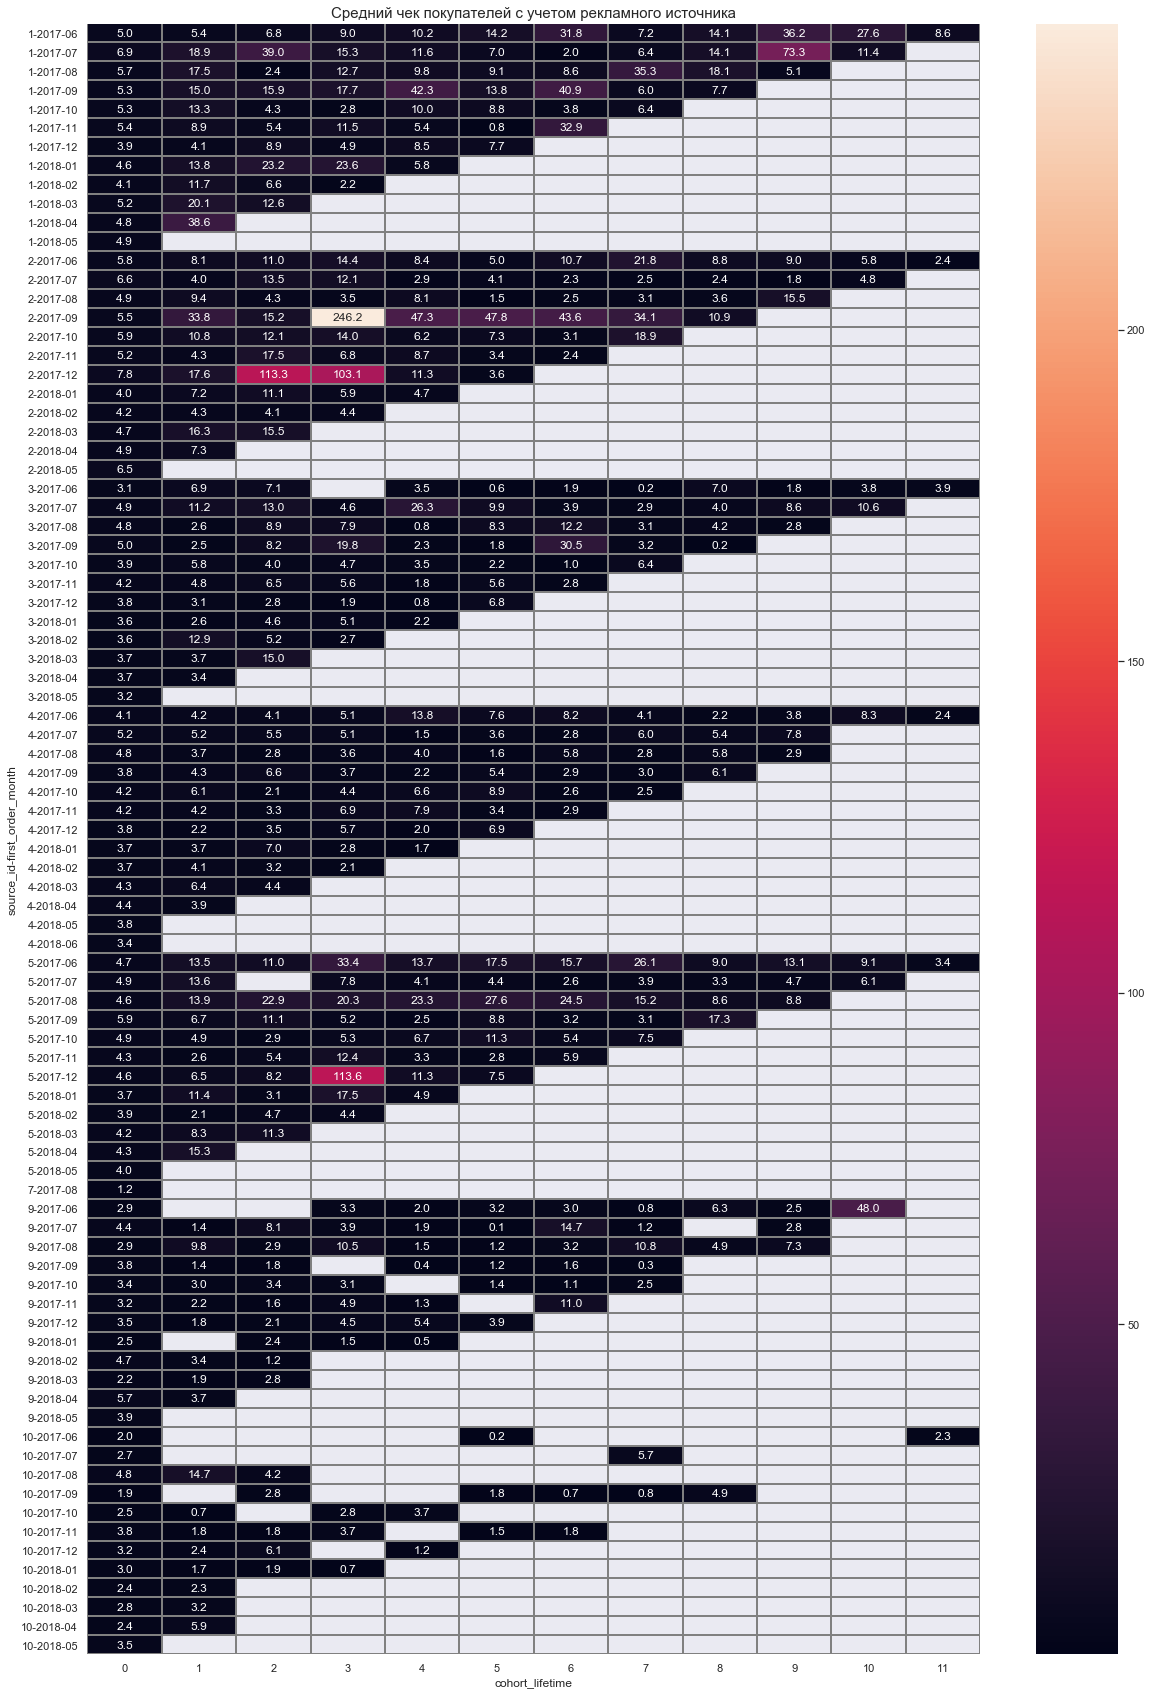

In [89]:
plt.figure(figsize = (20,30))
plt.title('Средний чек покупателей с учетом рекламного источника', fontsize=15)
sns.heatmap(session_source_by_cohorts_pivot, annot=True, fmt='.1f', linewidths=1, linecolor='gray');

#### Вывод 
**Средний чек** 
- В целом можно сказать, что средний чек для вновь появляющихся когорт выше в 2017 году по сравнению с 2018. 
- Наиболее высокие показатели по среднему чеку зафиксированы на четвертый месяц жизни когорты. Так, максимальный показатель зафиксирован для когорты, которая появилась в сентябре 2017 года – 138.7. 
- Интересно, что с увеличением lifetime когроты, растет и ее средний чек. Так, например, для когорты, которая появилась в июне 2017 года средний чек изначально был равен 4.7, а через 10 месяцев уже 25.7, то есть средний чек вырос более чем в 5 раз. Однако следует заметить, что для когорт, которые появились в 2018 году этот рост не такой значительный. Так, например, для когорты, которая появилась в феврале 2018 года средний чек изначально был равен 4.2, а через 3 месяца 6.9. Для сравнения для когорты, которая появилась в июне 2017 года, этот показатель равен 35.8 по сравнению с 4.7 в первый месяц существования когорты. 
--- 
**Средний чек с учетом категории устройства**
- Что касается среднего чека с учетом категории устройства пользователя, то тут можно отметить, что средний чек значительно выше для десктопных устройств. Интересно, что существенный рост среднего чека на 3ем lifetime-когорты характерен только для десктопных устройств. 
- Как для десктопных, так и для touch-устройств рост среднего чека сменяется его падением. Рассмотрим, когорту которая появилась в октябре 2017 года. Для десктопа: средний чек изначально равен 4.7, на первом месяце жизни – 8.5, в следующем месяце понижение – до 5.5, а на третьем опять рост до 7.1. Для touch-устройств: изначально средний чек равен 4.4, в следующем месяце – 10.4, затем можно наблюдать понижение до 3.2, то есть более, чем в три раза. Таким образом, для большинства когорт можно говорить о попеременно чередовании роста среднего чека его падением. 
--- 
**Средний чек с учетом рекламного источника**
- Наиболее высокими показателями по среднему чеку характеризуются источники 1, 2 и 5. 
- Наиболее низкими 7, 9, 10. 
- Пиковые показатели также зафиксированы на 3-ем lifetime жизни когорты. 
- Следует сказать, что с появлением новых когорт рост среднего чека попеременно снижается его падаением. Например, возьмем источник 2. Для когорты, которая появилась в июне 2017 года средний чек равен 5.8, для когорты, которая появилась в июле средний чек вырос и стал равен 6.6, далее чек снова падает – для когорты, которая появилась в августе, он равен 4.9, а для сентябрьской снова характерен рост, так как для нее среднийч чек равен 5.5. 

**LTV**

In [90]:
#Посчитаем количество новых покупателей за каждый месяц: 
cohort_sizes = orders_log.groupby('first_order_month').agg({'uid':'nunique'}).reset_index()
cohort_sizes.columns = ['first_order_month', 'n_buyers']
cohort_sizes.head()

,first_order_month,n_buyers
0,2017-06-01,2023
1,2017-07-01,1923
2,2017-08-01,1370
3,2017-09-01,2581
4,2017-10-01,4340


In [91]:
#Сгруппируем таблицу заказов по месяцу первой покупки и месяцу каждого заказа и сложим выручку: 
cohorts = orders_log.groupby(['first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts.head()

,first_order_month,order_month,revenue
0,2017-06-01,2017-06-01,9557.49
1,2017-06-01,2017-07-01,981.82
2,2017-06-01,2017-08-01,885.34
3,2017-06-01,2017-09-01,1931.30
4,2017-06-01,2017-10-01,2068.58


In [92]:
#Добавим в таблицу cohorts данные о том, сколько людей первый раз совершили покупку в каждый месяц:
report = pd.merge(cohort_sizes, cohorts, on='first_order_month')

In [93]:
#LTV рассчитываемя из валовой прибыли. У нас нет этого показателя. Примем маржинальность за единицу. 
#Добавим возраст когорты: 
margin_rate = 1
    
report['gp'] = report['revenue'] * margin_rate
report['age'] = (report['order_month'] - report['first_order_month']) / np.timedelta64(1, 'M')
report['age'] = report['age'].round().astype('int')

In [94]:
#Рассчитаем ltv: 
report['ltv'] = report['gp'] / report['n_buyers']

In [95]:
report

,first_order_month,n_buyers,order_month,revenue,gp,age,ltv
0,2017-06-01,2023,2017-06-01,9557.49,9557.49,0,4.724414
1,2017-06-01,2023,2017-07-01,981.82,981.82,1,0.485329
2,2017-06-01,2023,2017-08-01,885.34,885.34,2,0.437637
3,2017-06-01,2023,2017-09-01,1931.30,1931.30,3,0.954671
4,2017-06-01,2023,2017-10-01,2068.58,2068.58,4,1.022531
...,...,...,...,...,...,...,...
74,2018-03-01,3533,2018-05-01,1114.87,1114.87,2,0.315559
75,2018-04-01,2276,2018-04-01,10600.69,10600.69,0,4.657597
76,2018-04-01,2276,2018-05-01,1209.92,1209.92,1,0.531599
77,2018-05-01,2988,2018-05-01,13925.76,13925.76,0,4.660562


In [96]:
#Исключим из анализа когорты, которые прожили меньше 6 месяцев (все когорты, которые появились позже декабря 2017 года). 
#Также оставим только период, за который мы анализируем данные, то есть полгода с появления когорты: 
age_list = [0, 1, 2, 3, 4, 5]
report = report.query('first_order_month < "2018-01-01" and age in @age_list')

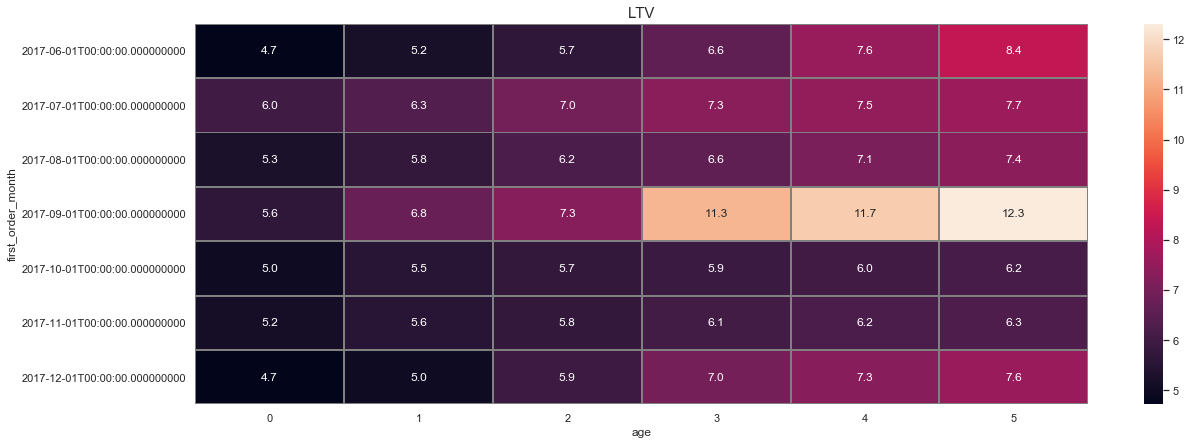

In [97]:
#Визуализируем полученный результат: 
output = report.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='ltv', 
        aggfunc='mean').round(2)
output = output.cumsum(axis=1)
plt.title('LTV', fontsize=15)
sns.heatmap(output, annot=True, fmt='.1f', linewidths=1, linecolor='gray');

In [98]:
#Проделаем все то же самое, но с добавлением данных по категории устройства пользователя: 
ltv_device = session_device.query('buy_ts >= start_ts and buy_ts <= end_ts')

In [99]:
cohort_sizes_device = ltv_device.groupby(['device', 'first_order_month']).agg({'uid':'nunique'}).reset_index()
cohort_sizes_device.columns = ['device', 'first_order_month', 'n_buyers']
cohort_sizes_device.head()

,device,first_order_month,n_buyers
0,desktop,2017-06-01,1580
1,desktop,2017-07-01,1364
2,desktop,2017-08-01,971
3,desktop,2017-09-01,1790
4,desktop,2017-10-01,3107


In [100]:
cohorts_device = ltv_device.groupby(['device', 'first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts_device.head()

,device,first_order_month,order_month,revenue
0,desktop,2017-06-01,2017-06-01,6943.99
1,desktop,2017-06-01,2017-07-01,343.23
2,desktop,2017-06-01,2017-08-01,342.29
3,desktop,2017-06-01,2017-09-01,697.98
4,desktop,2017-06-01,2017-10-01,697.85


In [101]:
report_device = pd.merge(cohort_sizes_device, cohorts_device, on=['first_order_month', 'device'])

In [102]:
report_device['gp'] = report_device['revenue'] * margin_rate
report_device['age'] = (report_device['order_month'] - report_device['first_order_month']) / np.timedelta64(1, 'M')
report_device['age'] = report_device['age'].round().astype('int')

In [103]:
report_device['ltv'] = report_device['gp'] / report_device['n_buyers']

In [104]:
report_device = report_device.query('first_order_month < "2018-01-01" and age in @age_list')

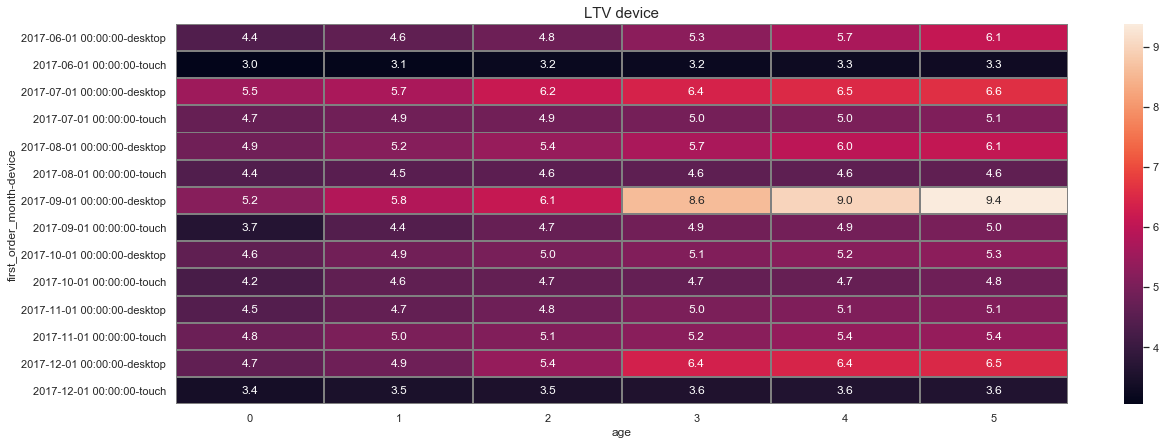

In [105]:
output_device = report_device.pivot_table(
                index=['first_order_month', 'device'], 
                columns='age', 
                values='ltv', 
                aggfunc='mean').round(2)
output_device = output_device.cumsum(axis=1)
plt.title('LTV device', fontsize=15)
sns.heatmap(output_device, annot=True, fmt='.1f', linewidths=1, linecolor='gray');

In [106]:
#Проделаем то же самое, но уже с учетом данных по рекламному источнику: 
ltv_source = session_source.query('buy_ts >= start_ts and buy_ts <= end_ts')

In [107]:
cohort_sizes_source = ltv_source.groupby(['source_id', 'first_order_month']).agg({'uid':'nunique'}).reset_index()
cohort_sizes_source.columns = ['source_id', 'first_order_month', 'n_buyers']
cohort_sizes_source.head()

,source_id,first_order_month,n_buyers
0,1,2017-06-01,289
1,1,2017-07-01,262
2,1,2017-08-01,168
3,1,2017-09-01,341
4,1,2017-10-01,498


In [108]:
cohorts_source = ltv_source.groupby(['source_id', 'first_order_month','order_month']).agg({'revenue': 'sum'}).reset_index()
cohorts_source.head()

,source_id,first_order_month,order_month,revenue
0,1,2017-06-01,2017-06-01,1264.19
1,1,2017-06-01,2017-07-01,43.54
2,1,2017-06-01,2017-08-01,88.09
3,1,2017-06-01,2017-09-01,99.51
4,1,2017-06-01,2017-10-01,203.05


In [109]:
report_source = pd.merge(cohort_sizes_source, cohorts_source, on=['first_order_month', 'source_id'])

In [110]:
report_source['gp'] = report_source['revenue'] * margin_rate
report_source['age'] = (report_source['order_month'] - report_source['first_order_month']) / np.timedelta64(1, 'M')
report_source['age'] = report_source['age'].round().astype('int')

In [111]:
report_source['ltv'] = report_source['gp'] / report_source['n_buyers']

In [112]:
report_source = report_source.query('first_order_month < "2018-01-01" and age in @age_list')

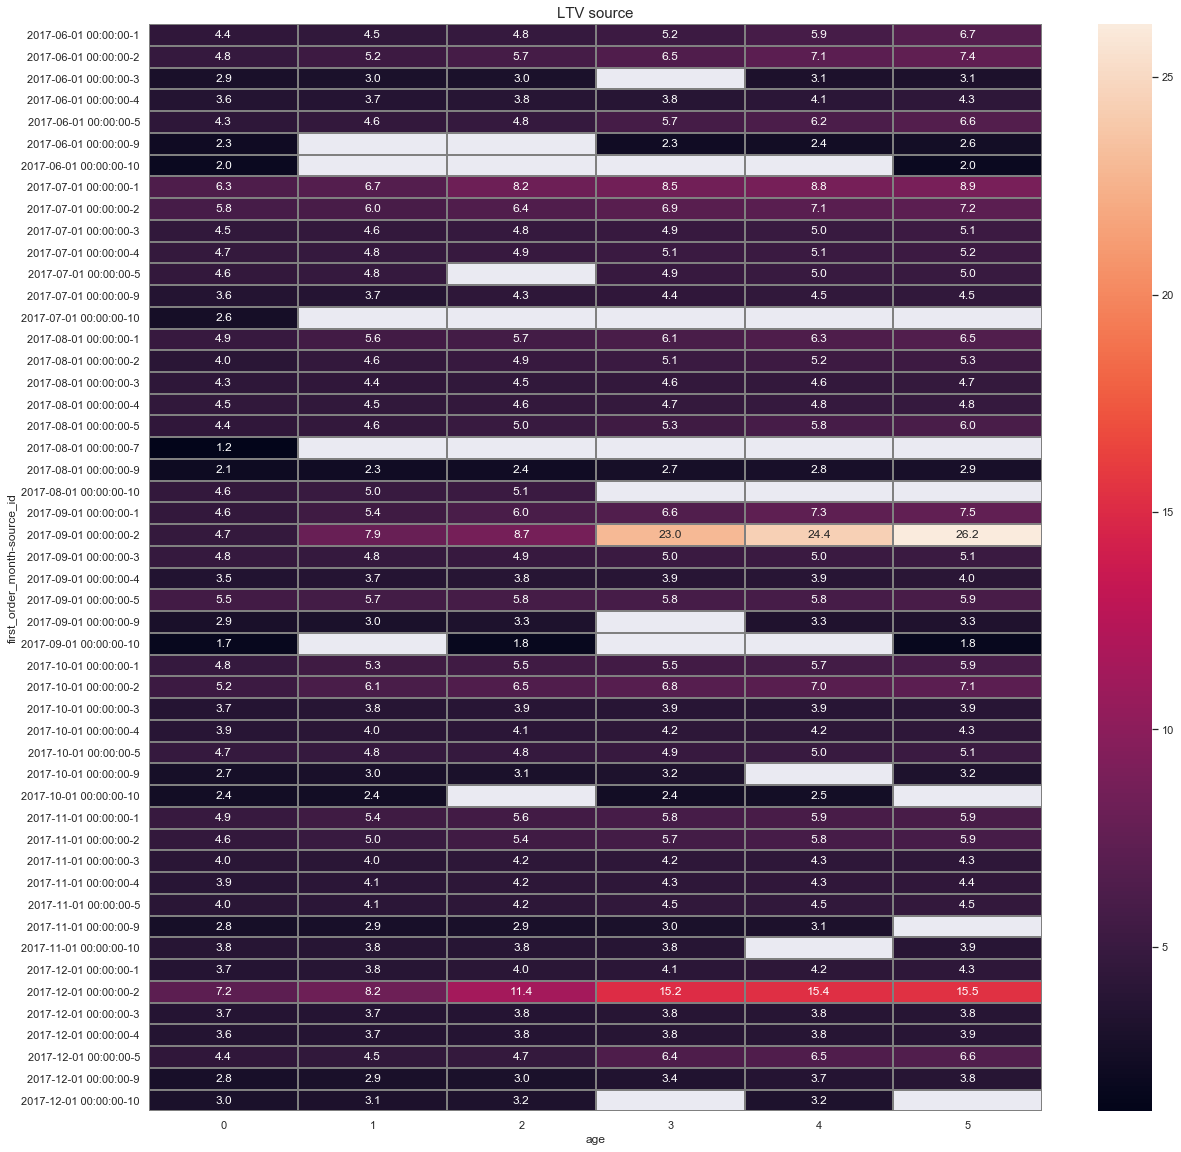

In [113]:
output_source = report_source.pivot_table(
                index=['first_order_month', 'source_id'], 
                columns='age', 
                values='ltv', 
                aggfunc='mean').round(2)
output_source = output_source.cumsum(axis=1)
plt.figure(figsize = (20,20))
plt.title('LTV source', fontsize=15)
sns.heatmap(output_source, annot=True, fmt='.1f', linewidths=1, linecolor='gray');

#### Вывод
**LTV** 
- В качестве условного времени жизни когорты выберем 6 месяцев. Следовательно, из анализа будут исключены когорты, которые прожили меньшее количество времени (это когорты, которые появились в 2018 году). Анализировать мы будем только первые полгода жизни когорты, так как данные должны быть сопоставимы. 
- Наиболее высоким показателем LTV за полгода существования когорты характеризуются когорты, которые появились в сентябре 2017 года (12.3) и июне 2017 (8.4). Наименьший LTV характерен для когорт, которые появились в октябре и ноябре 2017 года – в среднем каждый покупаетель принес 6.2 и 6.3 выручки за 6 месяцев жизн соответсвенно. 
--- 
**LTV с учетом категории устройства** 
- Покупатели, которые пользуются десктопными устройствами, в среднем приносят больше выручки по сравнению с пользователями touch-устройств. Например, за 6 месяцев жизни когорты, которая появилась в июне 2017 года, показатель LTV для пользователей десктопных устройств составляет 6.1, по сравнанию с LTV равным 3.3 для пользователей touch-устройств. Исключением является только когорта, которая появилась в ноябре 2017 года. Показатель LTV равен 5.1 и 5.4 для пользователей desktop- и touch-устройств соответсвенно. 
--- 
**LTV с учетом рекламного источника** 
- Наибольшие показатели ltv характерны для 1, 2 и 5 источников. Самый высокий показатель LTV был зафиксирован для источника 2 для когорты, которая появилась в сентябре 2017 года: за 6 месяцев жизни в среднем пользователи, которые воспользовались Яндекс Афишой, благодаря этому источнику, принесли 26.2 выручки. 

###  Общий вывод
- Как мы выяснили, в среднем с момента посещения сайта до первой покупки проходит больше месяца (34 дня), но этот показатель не распределен нормально. Наиболее часто встречаются случаи, когда пользователь совершил покупку в тот же день, когда посетил сайт. В 50% случаев пользователи совершают покупку либо в тот же день, когда они посетили сайт, либо через день.
- График динамики совершения пользователями первых заказор по дням визуаль повторяет график активности пользователей. Наиболее часто покупки совершались в декабре 2017 года, что может объясняться покупками к новогодним праздникам. На декстопных устройствах покупки делались чаще. Наиболее активно покупки совершали пользователи, которые были привлечены третьим рекламным источником. 
- В день в среднем совершается 138 покупок. В неделю этот показатель равен – 951, а в месяц – 3 878. 
- При анализе среднего чека мы выяснили, что для 2017 года он был выше по сравнению с 2018. Наиболее высокие показатели по среднему чеку зафиксированы на четвертый месяц жизни когорты. Так, максимальный показатель зафиксирован для когорты, которая появилась в сентябре 2017 года и равен 138.7. Кроме того, с увеличением lifetime когроты, растет и ее средний чек. Так, например, для когорты, которая появилась в июне 2017 года средний чек изначально был равен 4.7, а через 10 месяцев уже 25.7, то есть средний чек вырос более чем в 5 раз. Однако следует заметить, что для когорт, которые появились в 2018 году этот рост не такой значительный. Так, например, для когорты, которая появилась в феврале 2018 года средний чек изначально был равен 4.2, а через 3 месяца 6.9. Для сравнения для когорты, которая появилась в июне 2017 года, этот показатель равен 35.8 по сравнению с 4.7 в первый месяц существования когорты.
- Далее кратко охарактеризуем средний чек с учетом категории устройств. Средний чек значительно выше для десктопных устройств. Для большинства когорт можно говорить о попеременно чередовании роста среднего чека его падением. Например, посмотрим средний чек для когорты, которая появилась в октябре 2017 года. ля десктопа: средний чек изначально равен 4.7, на первом месяце жизни – 8.5, в следующем месяце понижение – до 5.5, а на третьем опять рост до 7.1. Для touch-устройств: изначально средний чек равен 4.4, в следующем месяце – 10.4, затем можно наблюдать понижение до 3.2, то есть более, чем в три раза. 
- Что касается рекламных устройств, то наиболее высокими показателями по среднему чеку характеризуются источники 1, 2 и 5. Наиболее низкими 7, 9, 10.
- Наиболее высоким показателем LTV за полгода существования когорты характеризуются когорты, которые появились в сентябре 2017 года (12.3) и июне 2017 (8.4). Наименьший LTV характерен для когорт, которые появились в октябре и ноябре 2017 года – в среднем каждый покупаетель принес 6.2 и 6.3 выручки за 6 месяцев жизн соответсвенно.
- Покупатели, которые пользуются десктопными устройствами, в среднем приносят больше выручки по сравнению с пользователями touch-устройств. Например, за 6 месяцев жизни когорты, которая появилась в июне 2017 года, показатель LTV для пользователей десктопных устройств составляет 6.1, по сравнанию с LTV равным 3.3 для пользователей touch-устройств. 
- Наибольшие показатели ltv характерны для 1, 2 и 5 источников. Так, самый высокий показатель LTV был зафиксирован для источника 2 для когорты, которая появилась в сентябре 2017 года: за 6 месяцев жизни в среднем пользователи, которые воспользовались Яндекс Афишой, благодаря этому источнику, принесли 26.2 выручки.

### Маркетинг

**Сколько денег потратили? Всего / на каждый источник / по времени**

In [114]:
#Сколько всего потратили денег: 
costs['costs'].sum()

329131.62

In [115]:
#На каждый источник: 
costs.groupby('source_id')['costs'].sum()

source_id
1      20833.27
2      42806.04
3     141321.63
4      61073.60
5      51757.10
9       5517.49
10      5822.49
Name: costs, dtype: float64

In [116]:
#Затраы по времени посмотрим в разрезе по месяцам: 
costs['dt_month'] = costs['dt'].astype('datetime64[M]')
costs_per_month = costs.groupby(['source_id', 'dt_month']).agg({'costs':'sum'})
costs_per_month = costs_per_month.reset_index()

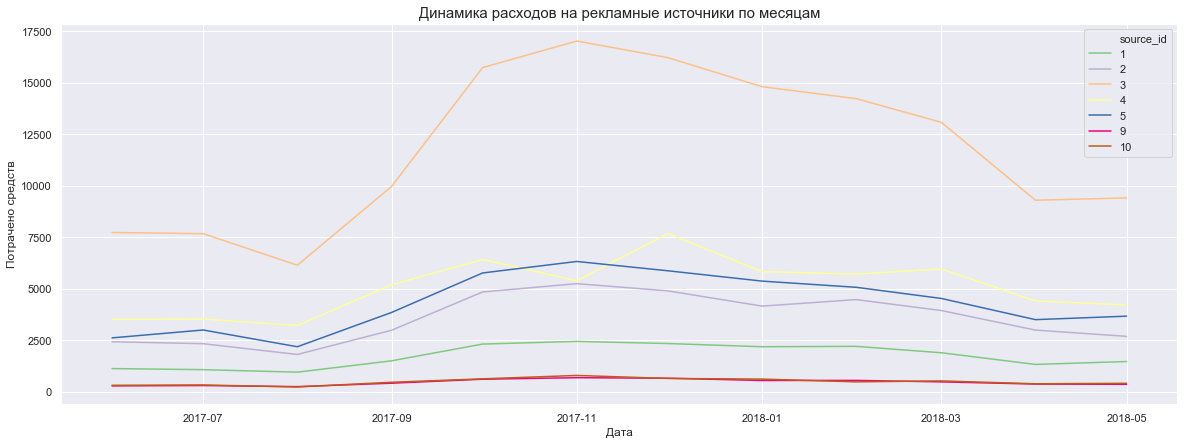

In [117]:
#Визуализируем полученный результат: 
costs_per_month_lineplot = sns.lineplot(x='dt_month', 
                                        y='costs', 
                                        hue='source_id', 
                                        legend='full',
                                        palette = 'Accent',
                                        data=costs_per_month)
costs_per_month_lineplot.set(xlabel='Дата', 
                             ylabel='Потрачено средств')
costs_per_month_lineplot.axes.set_title('Динамика расходов на рекламные источники по месяцам', 
                                         fontsize=15);

#### Вывод 
- Всего на рекламные источник было потрачено 329 132. 
- Наибольшее количество средств было затрачено на источник 3 (141321.63), 4 (61073.60) и 5 (51757.10). Наименьшее на источники 9 (5517.49) и 10 (5822.49). На источники 6, 7, 8 не было затрачено средств. 
- Что касается динамики расходов по месяцам, то можно сказать, что значительная часть средств была завтрачена в декабре 2017 года. 

**CAC: Сколько стоило привлечение одного покупателя из каждого источника?**

In [118]:
#Чтобы посчитать CAC добавим данные о расходах в отчет: 
report_new = pd.merge(report_source, costs_per_month, left_on=['source_id', 'first_order_month'], 
                                                      right_on=['source_id', 'dt_month'])

In [119]:
#Вычислим CAC: 
report_new['cac'] = report_new['costs'] / report_new['n_buyers']

In [120]:
#Вычислим средний CAC для каждого источника: 
report_new.groupby('source_id')['cac'].mean()

source_id
1      4.515394
2     11.028990
3     18.149682
4      8.139904
5      7.543691
9      6.150531
10     6.646220
Name: cac, dtype: float64

#### Вывод 
- Наиболее дорого стоило привлечение одного клиента из источников 2 (11) и 3 (18.1). 
- Дешевле всего обходилось привлечение клиентов из источников 1 (4.5) и 10 (6.6).

**На сколько окупились расходы (ROI)?**

In [121]:
#Рассчитаем ROMI: 
report_new['romi'] = report_new['ltv'] / report_new['cac']

In [122]:
report_new

,source_id,first_order_month,n_buyers,order_month,revenue,gp,age,ltv,dt_month,costs,cac,romi
0,1,2017-06-01,289,2017-06-01,1264.19,1264.19,0,4.374360,2017-06-01,1125.61,3.894844,1.123115
1,1,2017-06-01,289,2017-07-01,43.54,43.54,1,0.150657,2017-06-01,1125.61,3.894844,0.038681
2,1,2017-06-01,289,2017-08-01,88.09,88.09,2,0.304810,2017-06-01,1125.61,3.894844,0.078260
3,1,2017-06-01,289,2017-09-01,99.51,99.51,3,0.344325,2017-06-01,1125.61,3.894844,0.088405
4,1,2017-06-01,289,2017-10-01,203.05,203.05,4,0.702595,2017-06-01,1125.61,3.894844,0.180391
...,...,...,...,...,...,...,...,...,...,...,...,...
262,10,2017-11-01,103,2018-04-01,1.47,1.47,5,0.014272,2017-11-01,792.36,7.692816,0.001855
263,10,2017-12-01,63,2017-12-01,192.06,192.06,0,3.048571,2017-12-01,645.86,10.251746,0.297371
264,10,2017-12-01,63,2018-01-01,2.44,2.44,1,0.038730,2017-12-01,645.86,10.251746,0.003778
265,10,2017-12-01,63,2018-02-01,6.11,6.11,2,0.096984,2017-12-01,645.86,10.251746,0.009460


In [123]:
#Рассчитаем средний ROMI для каждого источника: 
report_new.groupby('source_id')['romi'].mean()

source_id
1     0.245395
2     0.165561
3     0.040634
4     0.094517
5     0.133311
9     0.106037
10    0.160767
Name: romi, dtype: float64

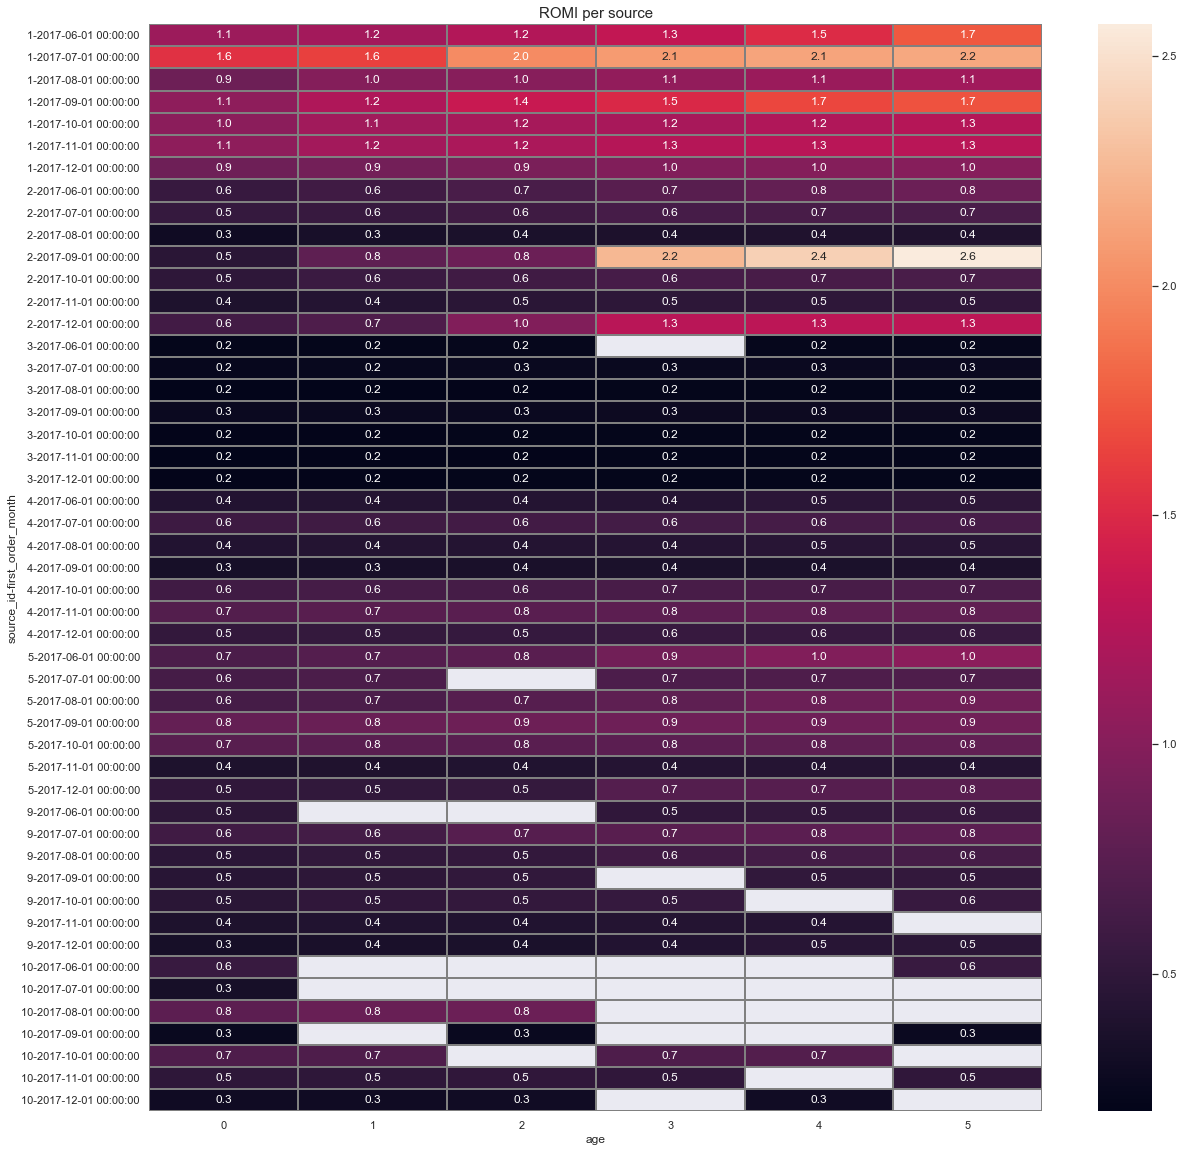

In [124]:
#Визуализиурем полученные результаты:
output_romi = report_new.pivot_table(
        index=['source_id', 'first_order_month'], 
        columns='age', 
        values='romi', 
        aggfunc='mean')
output_romi = output_romi.cumsum(axis=1).round(2)
plt.figure(figsize = (20,20))
plt.title('ROMI per source', fontsize=15)
sns.heatmap(output_romi, annot=True, fmt='.1f', linewidths=1, linecolor='gray');

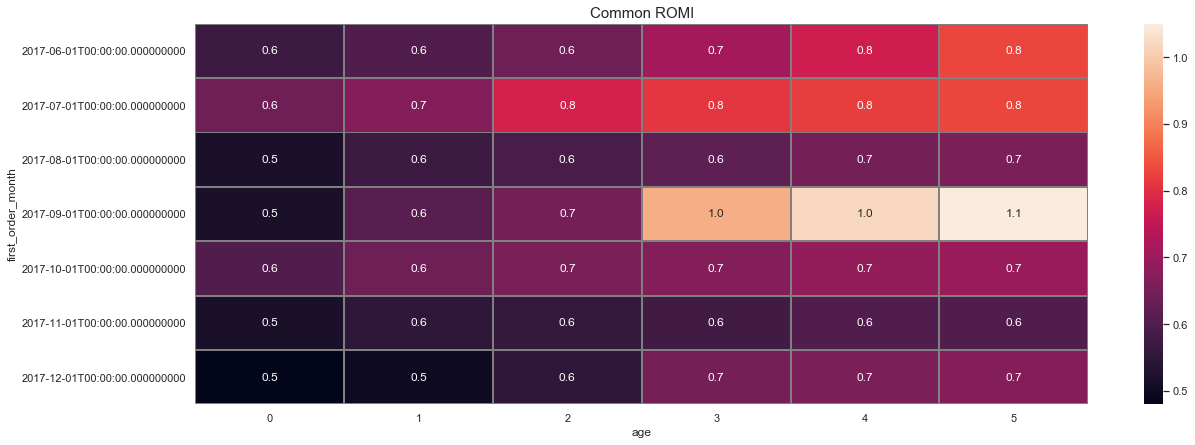

In [125]:
common_romi = report_new.pivot_table(
        index='first_order_month', 
        columns='age', 
        values='romi', 
        aggfunc='mean')
common_romi = common_romi.cumsum(axis=1).round(2)
plt.title('Common ROMI', fontsize=15)
sns.heatmap(common_romi, annot=True, fmt='.1f', linewidths=1, linecolor='gray');

#### Вывод 
- *Как мы видим из последнего графика (Common ROMI), окупилась только одна когорта: это когорта, которая появилась в сентябре 2017 года. Она окупилась на 6 месяц жизни: показатель ROMI равен 1.1. Наиболее низкую окупаемость показала когорта, появившаяся в ноябре 2017 года: ROMI=0.6 на шестой месяц жизни когорты.*
- В качестве наиболее окупаемого можно выделить источник 1. В большинстве случаев (за исключением когорт, которые появились в августе и декабре) он окупился уже на первом месяце жизни когорты. Так, показатель ROMI для первого источника находится в пределах от 1 до 1.6 в первой месяц жизни когорты. 
- Выскую окупаемость показал и второй источник, но только для когорты, которая появилась в сентябре 2017 года. Так на 6ом месяце жизни для этой когорты показатель ROMI составляет 2.6. Интересно, что для остальных когорт этот источник не показал окупаемость. Исключением является только когорта, которая появилась в декабре 2017 года: показатель ROMI на 6ой месяц жизни – 1.3. 
- Что касается остальных источников, то из них окупился только источник 5 для когорты, которая появилась в июне 2017 года: показатель ROMI на 6 месяц жизни когорты равен 1. 
- Наиболее низкую окупаемость показал источник 3, хотя, как мы помним, на него было потрачено наибольшее количество средств: показатель ROMI находится в пределах 0.3 и фактически не растет на протяжении жизни когорты. 

### Общий вывод  
- На рекламные источник было потрачено 329 132.
- Наибольшее количество средств было затрачено на источник 3 (141321.63), 4 (61073.60) и 5 (51757.10). Наименьшее на источники 9 (5517.49) и 10 (5822.49). На источники 6, 7, 8 не было затрачено средств. 
- Наиболее дорогим является привлечение клиентов из источников 2 и 3, а наиболее дешевым 1 и 10. 
- Абсолютным лидером по окупаемости является источник 1 – в большинстве случаев он окупается уже на первом месяце жизни когорты. Выскую окупаемость показал и второй источник, но только для когорты, которая появилась в сентябре 2017 года. Так на 6ом месяце жизни для этой когорты показатель ROMI составляет 2.6.
- Наименее окупаемым оказался источник 3: показатель ROMI находится в пределах 0.3 и фактически не растет на протяжении жизни когорты.

<a id='step_4'></a>
### 4. Общий вывод

Целью нашего исследования было помочь маркетологам оптимизировать маркетинговые затраты. 
Перечислим ключевые выводы нашего исследования по каждому из его разделов и дадим несколько рекомендаций отделу маркетинга. 

**Продукт** 

**DAU, WAU, MAU**
- Показатели DAU, WAU, MAU. DAU = 907, WAU = 5 716, MAU = 23 228. 
- *DAU, WAU, MAU с учетом категории устройства. Значительно большую активность проявляют пользователи desktop-устройств: разница для показателей примерно в два-три раза по сравнению с пользователями touch-устройств. Так, показатель DAU для десктопных устройств равен 659 по сравнению с показателем 252 для пользователей touch-устройств. Вероятно, десктопная версия сайта лучше оптимизирована, и поэтому пользователи отдают предпочтение именно ей.*
- *DAU, WAU, MAU с учетом рекламного источника. Прежде всего, отметим, что не было зафиксировано активности пользователей для источника 8. Также наименьшей активностью характеризиуются источники 6 и 7 (в первом случае все три показателя равны единице, а во втором только показатель MAU равен 2). Наибольшей активностью характеризуются пользователи, которые увидили рекламу портала на источниках 3 и 4. Для источника 3 показатели DAU, WAU, MAU равны 232, 1565 и 6758 соответственно. Для источника 4 – 275, 1 830 и 7 765. Таким образом, на источники 3 и 4 стоит обратить внимание как на способ привлечь наиболее активных пользователей.*

**Пользовательская сессия**
- Среднее количество сессий в день – 987. Этот же показатель для различных категорий устройств – 494, для различных рекламных источников – 139. 
- Наибольшее количество сессий также приходится на период новогодних каникул.  

**ASL**
- Средняя продолжительность сессии 11 минут, но лучше ориентироваться на показатель моды, который равен 1 минуте.  

**Retention Rate**
- Показатель Retention Rate довольно низкий: на Афишу возвращается менее 10% пользователей. Кроме того, с появлением каждой новой когорты этот показатель незначительно, но снижается. Также чем больше lifetime когорты, тем ниже коэфициент удержания. 
- Retention Rate незначительно, но выше для десктопных устройств. Например, для когорты пользователей февраля 2018 года для desktop retention rate равен 6%, а для touch 5,2%. Исключеним является только когорта пользователей, которые впервые посетили сайт в декабре 2017 года.
- Наиболее высоким Retention Rate характеризуются источники 1, 2, 9, а 3 и 5 наиболее низкими. 
--- 
**Продажи**

**Когда люди начинают покупать?**
- В среднем с момента посещения сайта до первой покупки проходит больше месяца (34 дня). Так как показатель не распределен нормально, то стоит ориентироваться на показатель моды, согласно которому чаще всего пользователь совершает покупку в день посещения сайта. В 50% случаев пользователи совершают покупку либо в тот же день, когда они посетили сайт, либо через день.
- В новогодние праздники было совершено наибольшее количество покупок. На десктопных устройствах покупки совершаются чаще. Кроме того, наиболее активно покупали пользователи, которые были привлечены третьим рекламным источником. 

**Сколько раз покупают за период?**
- В день в среднем совершается 138 покупок. В неделю этот показатель равен – 951, а в месяц – 3 878.

**Какой средний чек?**
- Наиболее высокие показатели по среднему чеку зафиксированы на четвертый месяц жизни когорты. Так, максимальный показатель зафиксирован для когорты, которая появилась в сентябре 2017 года и равен 138.7. Кроме того, с увеличением lifetime когроты, растет и ее средний чек. 
- Средний чек значительно выше для десктопных устройств.
- Наиболее высокими показателями по среднему чеку характеризуются источники 1, 2 и 5, а наиболее низкими 7, 9 и 10. 

**Сколько денег приносят? (LTV)**
- *LTV. Наиболее высоким показателем характеризуются когорты, которые появились в сентябре 2017 года (12.3) и июне 2017 (8.4). Наименьший LTV характерен для когорт, которые появились в октябре и ноябре 2017 года – в среднем каждый покупаетель принес 6.2 и 6.3 выручки за 6 месяцев жизни соответсвенно.*
- *LTV с учетом категории устройств. Покупатели, которые пользуются десктопными устройствами, в среднем приносят больше выручки по сравнению с пользователями touch-устройств. Например, за 6 месяцев жизни когорты, которая появилась в июне 2017 года, показатель LTV для пользователей десктопных устройств составляет 6.1, по сравнанию с LTV равным 3.3 для пользователей touch-устройств.*
- *LTV с учетом рекламного источника. Наибольшие показатели ltv характерны для 1, 2 и 5 источников. Самый высокий показатель LTV был зафиксирован для источника 2 для когорты, которая появилась в сентябре 2017 года: за 6 месяцев жизни в среднем пользователи, которые воспользовались Яндекс Афишой, благодаря этому источнику, принесли 26.2 выручки.*  
--- 
**Маркетинг**

**Сколько денег потратили? Всего / на каждый источник / по времени**
- Совокупно на рекламные источники было потрачено 329 132. 
- Наиболее дорого обошлись источники 3 (141321.63), 4 (61073.60) и 5 (51757.10). Наименьшее на источники 9 (5517.49) и 10 (5822.49). На источники 6, 7, 8 не было затрачено средств.
**CAC для каждого источника**
- Дороже всего обходится привлечение клиентов из источников 2 (11.5) и 3 (18.4), а дешевле – 1 (4.7) и 10 (6.3).

**ROMI**
- **Окупилась только когорта, которая появилась в сентябре 2017 года: на 6 месяц жизни когорты показатель ROMI равен 1.1.**
- *В качестве наиболее окупаемого можно выделить источник 1. В большинстве случаев он окупился уже на первом месяце жизни когорты. Так, показатель ROMI для первого источника находится в пределах от 1 до 1.6 в первый месяц жизни когорты. Выскую окупаемость показал и второй источник, но только для когорты, которая появилась в сентябре 2017 года. Так на 6ом месяце жизни для этой когорты показатель ROMI составляет 2.6.*
- *Что касается остальных источников, то из них окупился только источник 5 для когорты, которая появилась в июне 2017 года: показатель ROMI на 6 месяц жизни когорты равен 1.* 
- *Наиболее низкую окупаемость показал источник 3, хотя, как мы помним, на него было потрачено наибольшее количество средств: показатель ROMI находится в пределах 0.3 и фактически не растет на протяжении жизни когорты.*
--- 
Резюмируя вышесказанное, маркетологам можно **порекомендовать** следующее:  
1. *Обратить внимание на источники 3 и 4 как на источники, за счет которых было привлечено большое количество активных пользователей, однако следует отметить, что на эти источники было затрачено наибольшее количество рекламных средств. Также источники 3 и 5 не характеризуются высоким показателем Retention Rate. Однако пользователи, которые были привлечены третьим источником совершали покупки наиболее активно*.  
- *Высокий средний чек характерен для источников 1, 2 и 5, а наиболее низкий 7, 9 и 10. Здесь следует отметить, что на источники 9 и 10 было затрачено наименьшее количество средств, а на источник 7 их вообще не было затрачено. 1, 2 и 5 источники также характеризуются высокими показателями ltv. Ни один из источников не окупается на 100%, тем не менее когортный анализ показал, что окупаемость происходить только для первого источника на 0-lifetime когорты. Таким образом, стоит обратить внимание на первый источник, а также с учетом неокупаемости источников кардинально пересмотреть бюджет на маркетинговые расходы.* 
- *Обратить внимание на когорту, которая появляется в сентябре 2017 года, так как для нее были зафиксированы высокие показатели ltv и romi*. **Более того, это единственная когорта, которая окупилась после 6го месяца жизни.** 
- *Обратить внимание на источник 1 как наиболее окупаемый: он окупается уже на 1м месяце жизни когорты. Также стоит обратить внимание на второй источник, так как для него была зафиксирована самая высокая окупаемость, для когорты, которая появилась в сентябре 2017 года на 6ой месяц жизни – 2.6.*
- *Отдельно слудет выделить источник 3. Как мы уже отметили выше, он характеризуется привлечением активных пользователей, но также этот источник имеет низкий показатель удержания пользователей и низкий ROMI, который находится в пределах 0.2 - 0.3.*
- *Пользовательская сессия длится не очень долго – 1 минуту. Следовательно, нужно подумать, как сделать так, чтобы пользователь принял решение о покупке за столь короткое время.*
- *Обратить внимание на мобильную версию сайта. Возможно, она плохо оптимизирована, поэтому пользователи предпочитают обращаться к сайту с десктопа.*